<a href="https://colab.research.google.com/github/Pauladrea03/supervised-and-unsupervised-learning-project/blob/main/no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Autores**
- Isabela Pareja Gil
- Juliana Rueda Arango
- Paula Andrea Ortega Sanjuan
- José David Martínez Espinosa


#**Librerías**

In [ ]:
!pip install kneed
!pip install scikit-optimizer
!pip install plotly

In [ ]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np

# Opciones de Pandas
pd.set_option('display.max_columns', None)

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import plotly.express as px
import graphviz
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

#Librerias estadísticas y de pruebas
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import RandomizedSearchCV
import time

from matplotlib.patches import Ellipse
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams

# Cargar datos

Dataset sobre ventas de automóviles de segunda mano

In [ ]:
!kaggle datasets download -d devantltd/analysing-second-hand-car-sales-data

In [ ]:
! unzip analysing-second-hand-car-sales-data.zip -d data

In [ ]:
df_cars = pd.read_csv('/content/data/second_hand_car_sales.csv')
df_cars

# Análisis exploratorio y limpieza de datos

*Descripción de los datos*

In [ ]:
def visual_check(df):
    pd.set_option('display.max_columns', None)

    print('Shape:\n',df.shape,'\n')

    print('Data Types:\n', df.dtypes,'\n\n')

    df_colum_duplicated=df.columns.duplicated()
    print("Columnas duplicadas:\n",df_colum_duplicated,'\n\n')

    df_fil_duplicated=df.duplicated()
    if df_fil_duplicated[1] == True:
        print("Filas duplicadas:\n",df_fil_duplicated,'\n\n')
    else:
        print('Filas duplicadas:\nNo hay filas duplicadas\n\n')

    df_colum_faltantes=df.columns[df.isnull().any()]
    print("Datos faltantes por columnas:\n",df_colum_faltantes,'\n\n')

visual_check(df_cars)

La base de datos sobre el mercado de automóviles de segunda mano o usados en el Reino Unido está compuesta por 50000 filas y 7 columnas, de las cuales encontramos variables numéricas como

*   Tamaño del motor en litros
*   Año de producción
*   Kilometraje
*   Precio en libras esterlinas

Y otras variables categóricas (object) como:

*   Fabricante
*   Modelo
*   Tipo de carburante

Sin embargo, después de un análisis a cada variable, se concluye que la columna 'Año de producción' es realmente categórica.

Por otro lado, no se observan filas ni columnas duplicadas, así como faltantes en esta base de datos.

In [ ]:
df_cars.rename(columns={
    "Engine Size (L)":"Engine_size",
    "Fuel Type":"Fuel_type",
    'Year of Manufacture':'Year_manufacture',
    'Price (£)':'Price'
},inplace=True)
df_cars.columns

## Análisis univariado

### 1. Variables númericas

*Analisis exploratorio*

In [ ]:
#Conversión de la variable numérica 'Año de producción' a variable categórica
df_cars['Year_manufacture'] = df_cars['Year_manufacture'].astype('object')
df_cars.dtypes

In [ ]:
numerical_columns = df_cars.select_dtypes(include=['number'])
display(numerical_columns.describe().T)

In [ ]:
def num_vis(df):
    numeric_columns = df.select_dtypes(include='number').columns
    n_cols = 3
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols
    fig_hist = make_subplots(n_rows, n_cols, subplot_titles=[f'Histograma {column}' for column in numeric_columns],shared_yaxes=True)
    for i, column in enumerate(numeric_columns):
        hist=go.Histogram(x=df[column], name=f'Histograma {column}',nbinsx=30,opacity=0.75,marker=dict(color='blue',line=dict(color='black',width=1)))
        fig_hist.add_trace(hist,row=(i//n_cols)+1, col=(i % n_cols)+1)
    fig_hist.update_layout(height=300 * n_rows, width=1000, title_text="Histogramas variables numéricas")
    fig_hist.show()

num_vis(df_cars)

Las variables numéricas tienen distribuciones casi uniformes, esto indica diversidad en los datos (?), falta de outliers y de tendencias marcadas en las variables. Los vehículos tienen tamaños de motor entre 1 y 5 litros, con frecuencias constantes y variabilidad de tamaños. La frecuencia del kilometraje y el precio de los vehículos es bastante constante, lo que indica que no hay preferencias en estas variables. El kilometraje de los carros va desde 0 hasta 200.000 kilometros y el precio entre 0 y aproximadamente 50.000 libras esterlinas

### 2. Variables categoricas

In [ ]:
def cat_summary(df, cat, plot=False):
    print(pd.DataFrame({cat: df[cat].value_counts(),
                        'Ratio': 100 * df[cat].value_counts() / len(df)}))
    print('##########################################')
    if plot:
        plt.figure(figsize=(12,6))
        sns.countplot(x=df[cat], data=df)
        plt.show(block=True)

cat_cols = [col for col in df_cars.columns if df_cars[col].dtypes == "O"]
for col in cat_cols:
    cat_summary(df_cars, col, plot=False)

Los resultados muestran una distribución equilibrada entre fabricantes, modelos, tipos de carburante y años de manufactura en los carros de segunda mano. Chevrolet, Volkswagen y Honda lideran entre los fabricantes, mientras que Model 3, A4 y Corolla son los modelos más comunes. En cuanto a los tipos de carburante, hay una representación casi igual entre híbridos, diésel, gasolina y eléctricos, lo que refleja una oferta diversificada y un posible interés creciente en vehículos más sostenibles. La frecuencia de los vehículos fabricados entre 2000 y 2020 es similar, con un pico de 2255 el año 2010.

In [ ]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "<b>Fabricantes de carros<br>de segunda mano</b>",
        "<b>Modelo de carros<br>de segunda mano</b>",
        "<b>% de tipo de carburante</b>"
    ),
    specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]],
    horizontal_spacing=0.10,
)

# Gráfico 1: Fabricantes
base1 = df_cars.groupby(['Manufacturer'])[['Year_manufacture']].count().reset_index().rename(columns={'Year_manufacture':'count'})
fig.add_trace(go.Pie(labels=base1['Manufacturer'], values=base1['count'], hole=0.3,
                     textinfo='label+percent',showlegend=False), row=1, col=1)

# Gráfico 2: Modelos
base2 = df_cars.groupby(['Model'])[['Year_manufacture']].count().reset_index().rename(columns={'Year_manufacture':'count'})
fig.add_trace(go.Pie(labels=base2['Model'], values=base2['count'], hole=0.3,
                     textinfo='label+percent',showlegend=False), row=1, col=2)

# Gráfico 3: Tipo de carburante
base3 = df_cars.groupby(['Fuel_type'])[['Year_manufacture']].count().reset_index().rename(columns={'Year_manufacture':'count'})
fig.add_trace(go.Pie(labels=base3['Fuel_type'], values=base3['count'], hole=0.3,
                     textinfo='label+percent',showlegend=False), row=1, col=3)

fig.update_layout(height=500, width=1500)
fig.show()


Hay una variedad de fabricantes y modelos disponibles en el mercado de segunda mano, lo que permite a los consumidores elegir según sus preferencias. Además, la notable representación de vehículos híbridos y eléctricos indica un cambio hacia opciones más sostenibles, posiblemente impulsado por la concientización ambiental.

In [ ]:
# Crear subplots con títulos
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "<b>Fabricantes de carros<br>de segunda mano</b>",
        "<b>Modelo de carros<br>de segunda mano</b>",
        "<b>% de tipo de carburante</b>"
    )
)

# Datos para 'Fabricantes'
base_manufactura = df_cars.groupby(['Manufacturer'])[['Year_manufacture']].count().reset_index().rename(columns={'Year_manufacture': 'count'}).sort_values('count', ascending=False)

# Añadir barras para 'Fabricantes'
fig.add_trace(go.Bar(x=base_manufactura['count'], y=base_manufactura['Manufacturer'], orientation='h',
                     marker=dict(color='skyblue'), showlegend=False), row=1, col=1)

# Datos para 'Modelos'
base_modelos = df_cars.groupby(['Model'])[['Year_manufacture']].count().reset_index().rename(columns={'Year_manufacture': 'count'}).sort_values('count', ascending=False)

# Añadir barras para 'Modelos'
fig.add_trace(go.Bar(x=base_modelos['count'], y=base_modelos['Model'], orientation='h',
                     marker=dict(color='skyblue'), showlegend=False), row=1, col=2)

# Datos para 'Tipo de carburante'
base_carburante = df_cars.groupby(['Fuel_type'])[['Year_manufacture']].count().reset_index().rename(columns={'Year_manufacture': 'count'}).sort_values('count', ascending=False)

# Añadir barras para 'Tipo de carburante'
fig.add_trace(go.Bar(x=base_carburante['count'], y=base_carburante['Fuel_type'], orientation='h',
                     marker=dict(color='skyblue'), showlegend=False), row=1, col=3)

# Ajustes de diseño para mejorar el espacio
fig.update_layout(
    height=600,  # Ajusta la altura
    width=1000,  # Ajusta el ancho
    margin=dict(l=20, r=20, t=50, b=20),  # Márgenes ajustados
   #title_text="<b>Análisis de carros de segunda mano</b>",  # Título de la figura
    title_x=0.5,  # Centra el título
)

# Mostrar el gráfico
fig.show()


El gráfico sugiere que no hay un solo líder absoluto en términos de fabricantes, modelos o tipos de carburante, lo que refleja una distribución relativamente uniforme en todas las categorías. Esto puede ser una indicación de un mercado equilibrado con una variedad de opciones para los compradores. Ademas muestra que, aunque los autos a gasolina y diesel siguien estando muy presentes, otros tipos de carburantes están ganando algo de terreno, reflejando quizás el interés creciente por vehículos más eficientes o ecológicos.

Debido a que la frecuencia de las variables categóricas parece ser uniforme, se sospecha que estas variables no serán de gran utilidad a la hora de aportar información al modelo. Por otro lado, la variable 'Modelo' presenta una inconsistencia, pues no todos los fabricantes producen todos los tipos de modelos, es decir, cada modelo debería ser propio de un fabricante; lo anterior sugiere que esta variable podría ser eliminada.

## Análisis bivariado

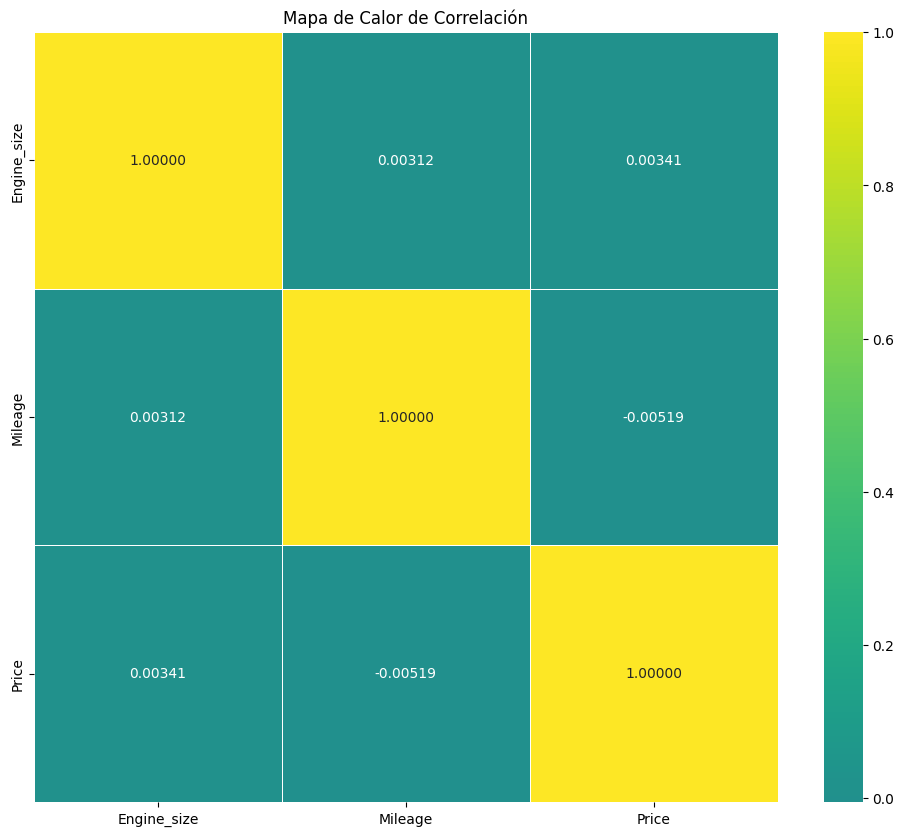

In [ ]:
#Mapa de calor de correlación
def graficar_mapa_correlacion(df):
    # Seleccionar las columnas numéricas
    numeric_vars = df.select_dtypes(include=['number']).columns

    # Calcular la matriz de correlación
    corr_matrix = df[numeric_vars].corr(method='pearson')  # Puedes cambiar 'pearson' por 'spearman'

    # Crear el mapa de calor
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', center=0, fmt='.5f', linewidths=0.5)
    plt.title('Mapa de Calor de Correlación')
    plt.show()

# Llamar a la función para generar el mapa de calor de correlación
graficar_mapa_correlacion(df_cars)

El mapa de calor muestra que no hay correlaciones fuertes entre las variables numéricas en este dataset. Las correlaciones cercanas a 0 (positivas o negativas) indican que no existe una relación lineal significativa entre las variables. Esto puede sugerir que las relaciones entre las variables son no lineales y requieren un análisis más profundo.

Este resultado también sugiere que, al usar algoritmos de clustering, los métodos de reducción de dimensionalidad como PCA podrían ayudar a capturar mejor la variabilidad del dataset, ya que las correlaciones entre las variables numéricas no explican mucho por sí solas.

In [ ]:
#Gráficos de barras - Tipos de carburante vs variables categóricas

# Primer gráfico: Conteo de tipos de carburante por modelos
fig1 = px.histogram(df_cars, x='Model', color='Fuel_type', barmode='group', color_discrete_sequence=px.colors.diverging.Spectral)
fig1.update_layout(title="<b> Cantidad de tipos de carburante por modelos<b><br>", xaxis_title="Modelos")
fig1.show()

# Segundo gráfico: Conteo de tipos de carburante por fabricante
fig2 = px.histogram(df_cars, x='Manufacturer', color='Fuel_type', barmode='group', color_discrete_sequence=px.colors.diverging.Spectral)
fig2.update_layout(title="<b>Cantidad de tipos de carburante por fabricante<b><br>", xaxis_title="Fabricantes")
fig2.show()

# Tercer gráfico: Conteo de modelos por fabricante
fig3 = px.histogram(df_cars, x='Manufacturer', color='Model', barmode='group', color_discrete_sequence=px.colors.diverging.Spectral)
fig3.update_layout(title="<b>Cantidad de modelos por fabricante<b><br>", xaxis_title="Fabricantes")
fig3.show()

Es importante aclarar que, en esta base de datos los modelos no están asociados exclusivamente a un fabricante específico. En cambio, los diferentes fabricantes han producido todos los modelos enlistados, lo que podría presentaer una contradicción con la realidad de los fabricantes.

La grafica de los tipos de carburante por modelos refleja que:

*   Los modelos de tipo electrico más vendidos en el mercado de autos usados son mayormente del Fiesta
*   Los modelos de tipo Gasolina más populares son el Golf y el 3 Series
*   Para los modelos usados con carburante Diesel, los más vendidos son el A4 y el Model 3
*   Los modelos como el Cruze, Civic, Corolla y Altima destacan en el segmento de híbridos.

La grafica de tipo de carburantes por modelos nos ayuda a identificar que:

*   Los autos fabricados por Tesla y Ford que se venden más en el mercado de segunda mano son en su mayoría eléctricos.
*   Las marcas Audi, Volkswagen y Nissan fabrican principalmente autos que utilizan gasolina.
*   Los autos de Mercedes-Benz, Toyota, Honda y BMW se destacan por sus modelos con carburante diésel.
*   Por su parte, Tesla también sobresale en la producción de vehículos híbridos.
   
La grafica 3 nos ayuda a identificar la cantidad de modelos por fabricante y podemos concluir que:

*   Mercedes-Benz y Audi venden carros de segunda en su mayoría del modelo Cruze. Ford, Honda y Tesla del modelo Corolla.
*   Chevrolet se destaca por vender más el modelo A4, mientras que el modelo Corolla es vendido en menor cantidad.
*   Volkswagen tiene una mayor venta del modelo C-Class, siendo el Cruze su modelo menos vendido.
*   Nissan concentra la venta de autos usados en los modelos 3 Series y Golf, mientras que los modelos menos vendidos son el C-Class y el Altima.
*   BMW es el principal fabricante del modelo Fiesta, y su modelo menos vendido en segunda mano es el Corolla.

In [ ]:
#Evolución del tamaño del motor promedio vs variables categóricas

df_cars_filtered1 = df_cars[['Year_manufacture', 'Engine_size', 'Manufacturer']]
df_cars_grouped1 = df_cars_filtered1.groupby(['Year_manufacture','Manufacturer']).mean().reset_index()
fig1=px.line(df_cars_grouped1,x='Year_manufacture',y='Engine_size',color='Manufacturer',
              title='Evolución del tamaño del motor promedio por fabricante',color_discrete_sequence=px.colors.diverging.Spectral)
fig1.update_layout(xaxis_title='Año de fabricación',yaxis_title='Tamaño del motor promedio')
fig1.show()

df_cars_filtered3= df_cars[['Year_manufacture', 'Engine_size', 'Fuel_type']]
df_cars_grouped3= df_cars_filtered3.groupby(['Year_manufacture','Fuel_type']).mean().reset_index()
fig3=px.line(df_cars_grouped3,x='Year_manufacture',y='Engine_size',color='Fuel_type',
              title='Evolución del tamaño del motor promedio por tipo de carburante',color_discrete_sequence=px.colors.diverging.Spectral)
fig3.update_layout(xaxis_title='Año de fabricación',yaxis_title='Tamaño del motor promedio')
fig3.show()

El tamaño promedio del motor en cada año, por fabricante y tipo de carburante, muestra picos para Mercedes-Benz, BMW, Diesel e Hiíbrido. Esto quiere decir que en promedio los motores de estas categorías son mucho más grandes que los del resto, lo que podría traducirse en una mayor cilindrada, es decir, más potencia y capacidad de aceleración, con mejor rendimiento. En general, los motores manejan tamaños entre 2.9 litros y 3.4.

In [ ]:
# Filtramos el dataframe con las columnas necesarias
df_cars_filtered = df_cars[['Manufacturer', 'Mileage', 'Price']]

# Agrupamos por fabricante y modelo para obtener la media de kilometraje y precio
df_grouped = df_cars_filtered.groupby(['Manufacturer']).agg({'Mileage':'mean', 'Price':'mean'}).reset_index()

# Gráfico de dispersión con Kilometraje en el eje X y Precio en el eje Y
fig = px.scatter(df_grouped, x='Mileage', y='Price', color='Manufacturer',
                 size='Price',
                 title='Comparación de Kilometraje vs Precio por fabricante',
                 labels={'Mileage':'Kilometraje Promedio', 'Price':'Precio Promedio'},
                 color_discrete_sequence=px.colors.diverging.Spectral)
fig.show()

Este gráfico nos muestra que los precios de los vehículos usados varían ampliamente para un mismo kilometraje, no hay una relación fuerte entre ambos factores, sin embargo se identifica en dos puntos donde el precio es alto, el kilometrake es bajo. Los puntos se encuentran en el rango de 99000 y 104000 kilometros y entre 25000 y 26000 libras esterlinas, esto sugiere que la mayoria de autos en el mercado de segunda mano se encuentran en estos rangos medios. En conclusión, no se identifica un patrón claro o una marca que tenga dominio en términos de mejor kilometraje o precio más alto

## Datos atípicos

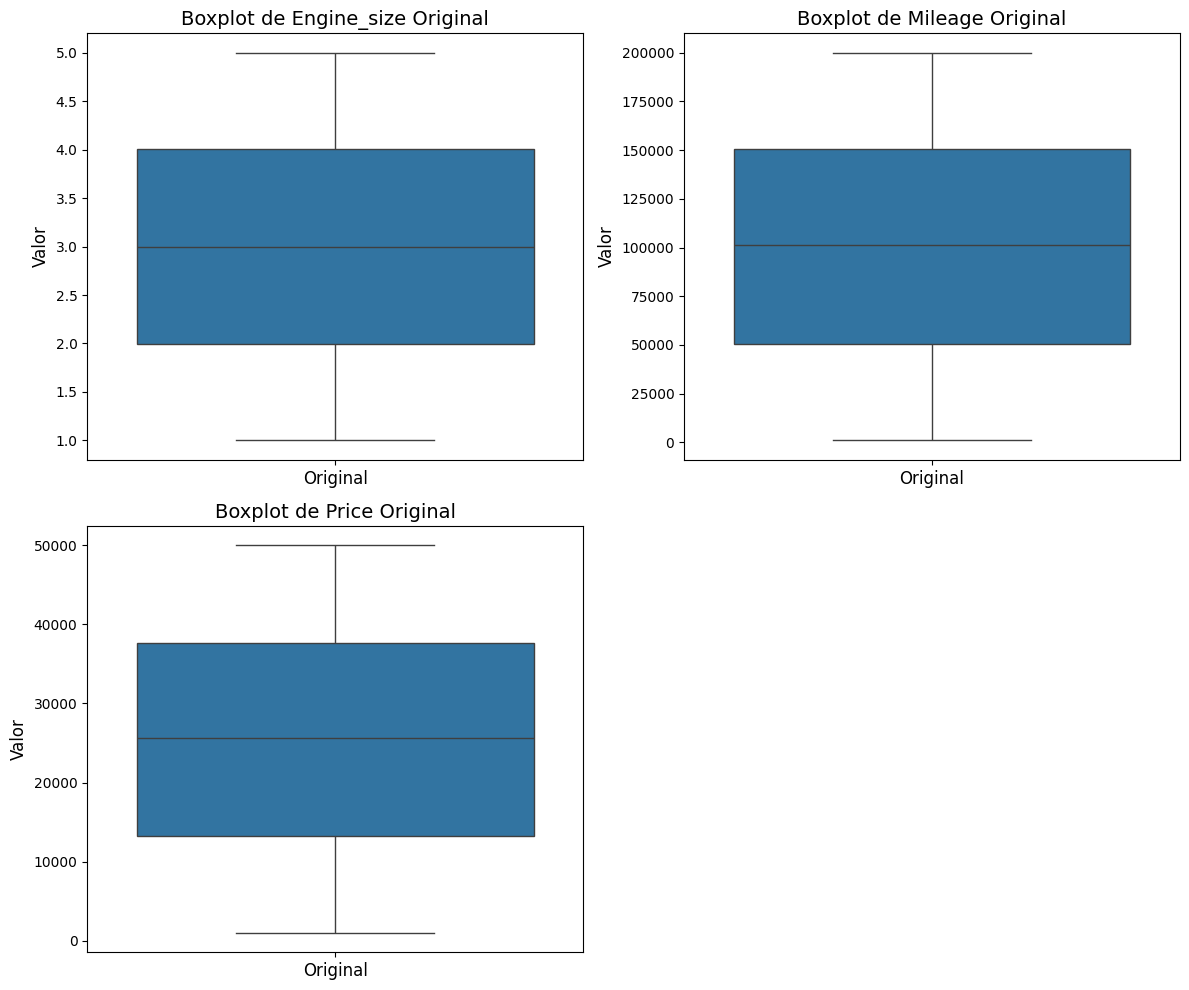

In [ ]:
#Identificacion de atipicos de manera grafica

def visual_outliers(df):
    numeric_cols = df.select_dtypes(include='number').columns

    # Boxplot
    df_comparison = pd.DataFrame()

    # Llenar el DataFrame con las columnas originales
    for col in numeric_cols:
        df_comparison[f'{col}_original'] = df_cars[col]  # Columna original
    num_vars = len(numeric_cols)

    # Determinar el número de filas y columnas para el diseño del subplot
    n_cols = 2
    n_rows = (num_vars + n_cols - 1) // n_cols  # Número de filas necesario

    #boxplots solo para los datos originales
    plt.figure(figsize=(12, 5 * n_rows))
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df_comparison[[f'{col}_original']])
        plt.title(f'Boxplot de {col} Original', fontsize=14)
        plt.xticks([0], ['Original'], fontsize=12)
        plt.xlabel('')
        plt.ylabel('Valor', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Histogramas
    n_cols = 2
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig_hist = make_subplots(n_rows, n_cols, subplot_titles=[f'Histograma {column}' for column in numeric_cols],shared_yaxes=True)
    for i, column in enumerate(numeric_cols):
        hist=go.Histogram(x=df[column], name=f'Histograma {column}',nbinsx=30,opacity=0.75,marker=dict(color='blue',line=dict(color='black',width=1)))
        fig_hist.add_trace(hist,row=(i//n_cols)+1, col=(i % n_cols)+1)

        kde = gaussian_kde(df[column], bw_method='scott')
        x = np.linspace(df[column].min(), df[column].max(), 1000)
        p = kde(x)
        hist_values, bin_edges = np.histogram(df[column], bins=30)
        kde_scaled = p * np.max(hist_values) / np.max(p)

        fig_hist.add_trace(go.Scatter(x=x, y=kde_scaled, mode='lines', name=f'KDE {column}', line=dict(color='red')), row=(i // n_cols) + 1, col=(i % n_cols) + 1)

    fig_hist.update_layout(height=300 * n_rows, width=800, title_text="Histogramas variables numéricas con KDE")
    fig_hist.show()

visual_outliers(df_cars)

Por medio de los gráficos no se aprecian atípicos ni sesgos en las variables numéricas. Los boxplot muestran una mediana centrada, sin embargo la variabilidad entre los valores de las variables es amplia.

**Cantidad de atípicos encontrados con el rango intercuartílico**

In [ ]:
# Identificacion de atipicos de variables numericas

numeric_cols = df_cars.select_dtypes(include=[np.number]).columns
outliers_count = {}

# Identificar y contar atipicos usando IQR
for col in numeric_cols:
    col_data = df_cars[col].dropna()

    # Calcular IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (df_cars[col] < lower_bound) | (df_cars[col] > upper_bound)
    outliers_count[col] = np.sum(outliers)

# Creacion un DataFrame con las cantidades de atipicos
outliers_df = pd.DataFrame(list(outliers_count.items()), columns=['Variable', 'Cantidad de Atípicos'])
print(outliers_df)

      Variable  Cantidad de Atípicos
0  Engine_size                     0
1      Mileage                     0
2        Price                     0


Con el rango intercuartílico se intentó encontrar outliers puntuales que no eran apreciables en los gráficos, sin embargo, los resultados confirman la hipótesis planteada de la no existencia de ellos.

## Pruebas de normalidad de algunas variables relevantes


In [ ]:
#Prueba de normalidad estadistica

def prueba_normalidad(df, variables):

    for var in variables:
        stat, p_value = stats.shapiro(df[var].dropna())
        print(f'Prueba de Normalidad de Shapiro-Wilk para {var}:')
        print(f'Estadístico: {stat}, Valor-p: {p_value}')
        if p_value > 0.05:
            print('No se rechaza la hipótesis nula: los datos parecen seguir una distribución normal.')
        else:
            print('Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.')
        print("\n")

# Realizar la prueba de normalidad
variables = numerical_columns
prueba_normalidad(df_cars, variables)

Prueba de Normalidad de Shapiro-Wilk para Engine_size:
Estadístico: 0.9543189651158617, Valor-p: 3.056555027145134e-78
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para Mileage:
Estadístico: 0.9543559809050457, Valor-p: 3.1880934271765794e-78
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para Price:
Estadístico: 0.9549849687873629, Valor-p: 6.552727874069393e-78
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.




/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50000.



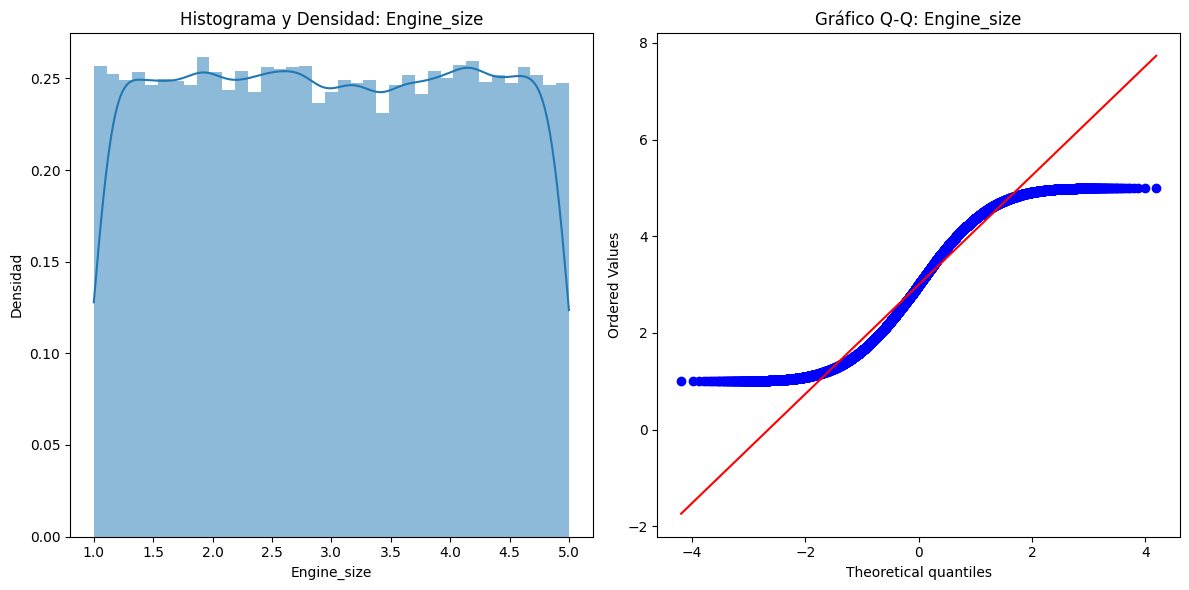

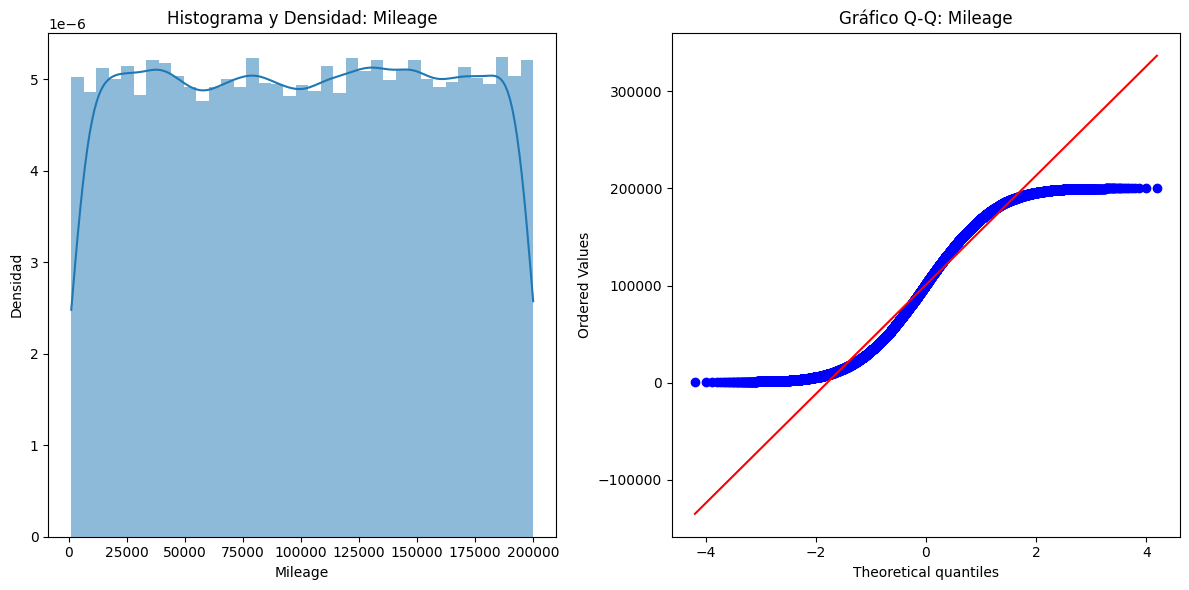

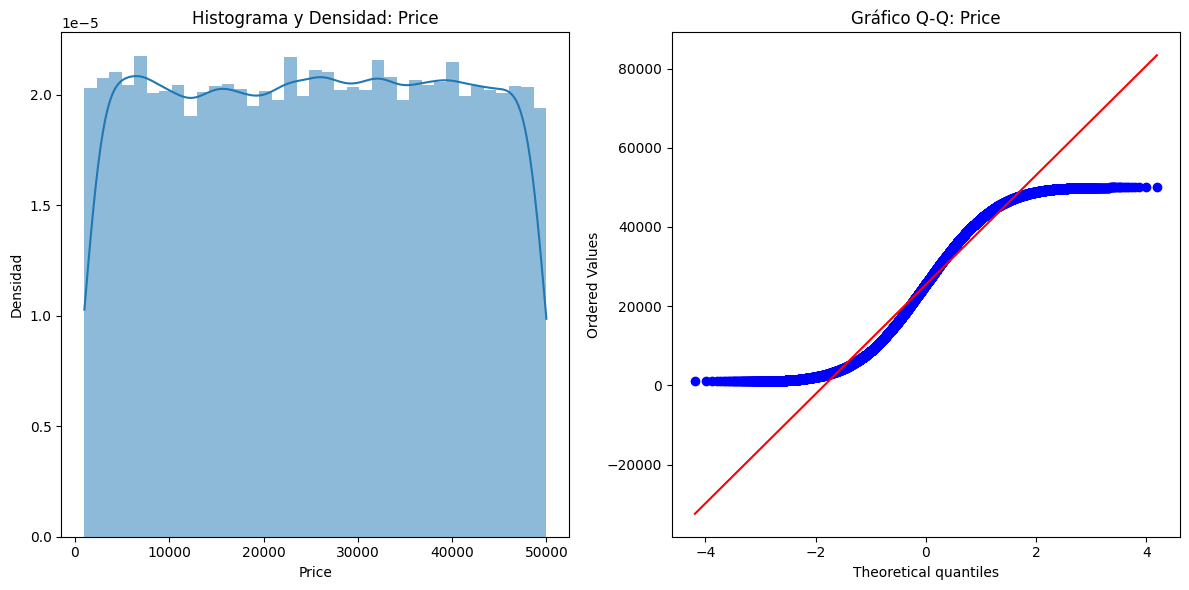

In [ ]:
#Prueba de normalidad grafica

def evaluar_normalidad(df, variables):

    for var in variables:
        plt.figure(figsize=(12, 6))

        # Histograma con línea de densidad
        plt.subplot(1, 2, 1)
        sns.histplot(df[var], kde=True, stat='density', linewidth=0)
        plt.title(f'Histograma y Densidad: {var}')
        plt.xlabel(var)
        plt.ylabel('Densidad')

        # Gráfico Q-Q
        plt.subplot(1, 2, 2)
        stats.probplot(df[var].dropna(), dist="norm", plot=plt)
        plt.title(f'Gráfico Q-Q: {var}')

        plt.tight_layout()
        plt.show()

evaluar_normalidad(df_cars, variables)

Las pruebas iniciales de normalidad con Shapiro-Wilk, las gráficas Q-Q y densidad, arrojaron que ninguna de las variables cumplen una distribución normal, por lo que se podría presentar ciertas complicaciones en algunos de los modelos.

### Transformación de los datos en busca de distribución normal

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_columns = df_cars.select_dtypes(include=['number'])

#Copia de dataframe para modificar
dfc_transformado = df_cars.copy()

# Aplicar las transformaciones logarítmicas sobre la copia
dfc_transformado['Engine_size'] = np.log1p(dfc_transformado['Engine_size'])
dfc_transformado['Mileage'] = np.log1p(dfc_transformado['Mileage'])
dfc_transformado['Price'] = np.log1p(dfc_transformado['Price'])

dfc_transformado[['Engine_size', 'Mileage', 'Price']] = StandardScaler().fit_transform(dfc_transformado[['Engine_size', 'Mileage', 'Price']])  # Estandarización

In [ ]:
#Prueba de normalidad estadistica con la transformacion

variables = numerical_columns
def prueba_normalidad(df, variables):

    for var in variables:
        stat, p_value = stats.shapiro(df[var].dropna())
        print(f'Prueba de Normalidad de Shapiro-Wilk para {var}:')
        print(f'Estadístico: {stat}, Valor-p: {p_value}')
        if p_value > 0.05:
            print('No se rechaza la hipótesis nula: los datos parecen seguir una distribución normal.')
        else:
            print('Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.')
        print("\n")

# Realizar la prueba de normalidad
prueba_normalidad(dfc_transformado, variables)

Prueba de Normalidad de Shapiro-Wilk para Engine_size:
Estadístico: 0.9452036525193279, Valor-p: 2.1030303562991483e-82
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para Mileage:
Estadístico: 0.8473977409334004, Valor-p: 6.805549372275404e-108
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para Price:
Estadístico: 0.8748662862726724, Valor-p: 1.1089841113695158e-102
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.




/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50000.



A pesar de aplicar transformación logarítmica a las variables, estas no cumplen con el supuesto de normalidad, por lo tanto se retoma el análisis utilizando la base de datos original, "df_cars", sin la transformación.

# Elección de muestra aleatoria y escalamiento

In [ ]:
#Sample data frame
df_sample_cars = df_cars.sample(n=5000, random_state=42)
df_sample_cars.shape

(5000, 7)

In [ ]:
df_sample_cars

Manufacturer    Model  Engine_size Fuel_type Year_manufacture  \
33553      Chevrolet     Golf     1.002951    Diesel             2004   
9427           Honda    Civic     3.361567    Petrol             2016   
199           Nissan  Corolla     2.201474  Electric             2015   
12447          Tesla    Cruze     1.338103    Petrol             2019   
39489         Toyota   Altima     2.448674    Petrol             2017   
...              ...      ...          ...       ...              ...   
39885  Mercedes-Benz  Model 3     4.495875    Hybrid             2009   
17566          Honda  C-Class     4.051863    Petrol             2016   
16062      Chevrolet   Fiesta     1.331260    Petrol             2007   
48445            BMW  Model 3     3.006840    Petrol             2002   
20382     Volkswagen       A4     3.313765    Diesel             2007   

       Mileage  Price  
33553   161838  40533  
9427      3474   2927  
199     129959   9621  
12447    77035   5985  
39489   131672  28891  
...        ...    ...  
39885     2759  14236  
17566   119969  25562  
16062   129637  27571  
48445   142134   8359  
20382   112159  37312  

[5000 rows x 7 columns]

In [ ]:
# Calcular la frecuencia de cada categoría de cada variable categórica
frecuencia_manufacturer= df_sample_cars['Manufacturer'].value_counts(normalize=True)
frecuencia_model = df_sample_cars['Model'].value_counts(normalize=True)
frecuencia_fueltype = df_sample_cars['Fuel_type'].value_counts(normalize=True)
frecuencia_year = df_sample_cars['Year_manufacture'].value_counts(normalize=True)
#Aplicar la codificación de frecuencia
df_sample_cars['Manufacturer'] = df_sample_cars['Manufacturer'].map(frecuencia_manufacturer).astype('object')
df_sample_cars['Model'] = df_sample_cars['Model'].map(frecuencia_model).astype('object')
df_sample_cars['Fuel_type'] = df_sample_cars['Fuel_type'].map(frecuencia_fueltype).astype('object')
df_sample_cars['Year_manufacture'] = df_sample_cars['Year_manufacture'].map(frecuencia_year).astype('object')
df_sample_cars.head(3)

Manufacturer   Model  Engine_size Fuel_type Year_manufacture  Mileage  \
33553       0.1022  0.1032     1.002951     0.249           0.0394   161838   
9427         0.107   0.101     3.361567    0.2432           0.0428     3474   
199         0.1002  0.0992     2.201474    0.2558           0.0456   129959   

       Price  
33553  40533  
9427    2927  
199     9621

In [ ]:
#Escalado de variables numéricas

# Identificamos las variables numéricas en el DataFrame
numerical_columns = df_sample_cars.select_dtypes(include=['float64', 'int64']).columns

# Aplicamos StandardScaler a las variables numéricas
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(df_sample_cars[numerical_columns])

# Creamos un nuevo DataFrame con las variables numéricas escaladas y los mismos índices
df_scaled_numerical = pd.DataFrame(scaled_numerical_data, columns=numerical_columns, index=df_sample_cars.index)

# Concatenamos las variables escaladas con las variables categóricas sin perder los índices
df_cars2 = pd.concat([df_scaled_numerical, df_sample_cars.drop(numerical_columns, axis=1)], axis=1)

# Mostramos las primeras filas del nuevo DataFrame
df_cars2.head()


Engine_size   Mileage     Price Manufacturer   Model Fuel_type  \
33553    -1.722959  1.055759  1.070245       0.1022  0.1032     0.249   
9427      0.320578 -1.712937 -1.580431        0.107   0.101    0.2432   
199      -0.684542  0.498414 -1.108601       0.1002  0.0992    0.2558   
12447    -1.432579 -0.426862 -1.364886        0.096   0.098    0.2432   
39489    -0.470365  0.528363  0.249654       0.0914  0.0956    0.2432   

      Year_manufacture  
33553           0.0394  
9427            0.0428  
199             0.0456  
12447           0.0466  
39489           0.0432

In [ ]:
df_cars_clean = df_cars2.copy()

# Aplicación algoritmo K-Means

In [ ]:
df_cars2_k = df_cars2.copy()
df_cars_clean_k = df_cars_clean.copy()

## Optimización de hiperparámetros

KMeans es un algoritmo de lenguaje no supervisado de clusterización, es decir, agrupa objetos en K clusters según patrones, tendencias o similitudes entre ellos. El agrupamiento es realizado por medio de la minimización de las distancias entre los objetos y el centroide del cluster, de manera que estén lo más cerca de los puntos del mismo cluster, pero lo más lejos de otros grupos.

Para la aplicación del algoritmo de Kmeans por SKLearn, es necesario preestablecer ciertos hiperparámetros, como el número de inicializaciones (n_init), el máximo de iteraciones (max_iter) y el más importante, la cantidad de clusters que el algoritmo va a crear.

max_iter y n_init

n_init: El número de inicializaciones indica la cantidad de veces que se  diferentes K centroides en el espacio. Esto se hace con el fin de mejorar los resultados de las inicializaciones, es decir, las ubicaciones de los centroides.

max_iter: Establece el número máximo de iteraciones, como una condición de parada, para que el algoritmo ajuste los centroides minimizando la distancia entre los objetos.

init: Puede adoptar el método de "k-means++", el cual selecciona de manera inteligente los centroides iniciales, o por otro lado el método "random" que elige de manera aleatoria los centroides.

In [ ]:
# Definir función de evaluación con silueta esperando ser cercana a 1
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Parámetros Kmeans
parametros = {
    'n_init': list(range(1, 20)),  # Número de inicializaciones
    'max_iter': list(range(100, 1000, 100))  # Iteraciones máximas
}

# Configurar búsqueda aleatoria
kmeans = KMeans()
random_search = RandomizedSearchCV(kmeans, param_distributions=parametros,
                                   n_iter=10, scoring= make_scorer(silhouette_scorer),
                                   cv=3, random_state=42, n_jobs=-1)

# Ejecutar búsqueda
start_time = time.time()
random_search.fit(df_cars2_k)
duration_rs = time.time() - start_time

# Mejor configuración de parámetros
best_params = random_search.best_params_
print(best_params)
print(f'El tiempo de duración es: {duration_rs}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]



{'n_init': 7, 'max_iter': 600}
El tiempo de duración es: 9.477969884872437


Por medio de una busqueda aleatoria, se optimizaron los hiperparámetros mencionados. El proceso anterior arrojó que es necesario utilizar 7 inicializaciones, con 400 iteraciones. Se elige el método "k-means++" para "init", pues como se mencionó anteriormente, este elige de manera inteligente los centroides iniciales.

**Identificación de K óptimo**

In [ ]:
# Identificación de K óptimo por coeficiente de silueta e inercia
#Argumentos del algoritmo
inertia_list = []
silhouette_scores = []

arg = {
    'init': 'k-means++',
    'n_init': 7, #Hiperparámetro
    'max_iter': 600, #Hiperparámetro
    'random_state': 567,
}

for k in range (2, 11):
    kmeans = KMeans(n_clusters = k, **arg) #Se define el algoritmo
    kmeans.fit(df_cars2_k) #Entrenamiento de datos escalados
    inertia_list.append(kmeans.inertia_)
    score_s = silhouette_score(df_cars2_k, kmeans.labels_)
    silhouette_scores.append(score_s)

In [ ]:
inertia_list #Al aumentar el número de clusters, disminuye la incercia o la distancia Cuadrática

[11221.276098040324,
 8935.411818068618,
 7083.818179765523,
 5960.386818550203,
 4940.658771344222,
 4307.024084443907,
 3720.40110102879,
 3476.697314945059,
 3295.2439634151115]

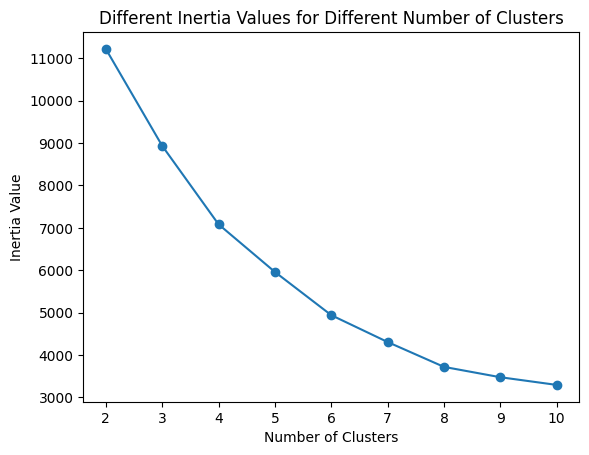

In [ ]:
# Gráfico de la inercia
plt.plot(range(2,11),inertia_list) #Gráficar de 2 a 10 clusters
plt.scatter(range(2,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

Según la gráfica, se puede intuir que el punto de codo podría estar entre 4 y 8 clusters.

In [ ]:
#Selección automática del punto de codo
kl = KneeLocator(
    range(2,11),
    inertia_list,
    curve = "convex",
    direction= "decreasing"
)

print(f'El k óptimo según el punto de codo es: {kl.elbow}')

El k óptimo según el punto de codo es: 6


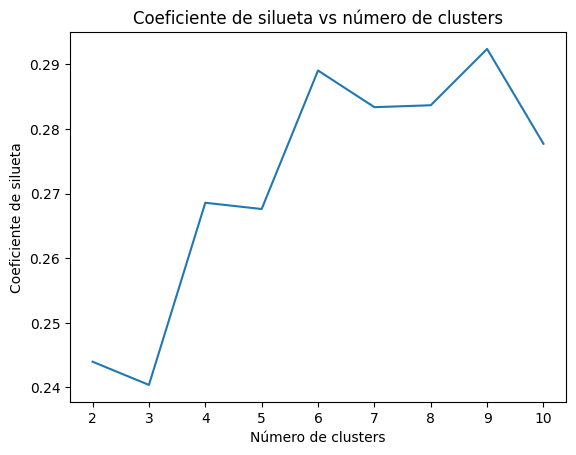

In [ ]:
#Visualización score de silueta vs k
plt.plot(range(2,11), silhouette_scores)
plt.xticks(range(2,11))
plt.xlabel("Número de clusters")
plt.ylabel("Coeficiente de silueta")
plt.title("Coeficiente de silueta vs número de clusters")
plt.show()

En k = 9 el coeficiente de silueta se maximiza, encontrando su punto más alto; sin embargo, entre 5 y 6 clusters hay un aumento importante del coeficiente, lo que podría inferir que 6 grupos podrían ser la mejor cantidad de clusters debido a su simplicidad y significancia. Aunque con el método de inercia la elección de clusteres es 6, la gráfica del coeficiente de silueta evidencia que 9 también podría ser una buena selección de K óptimo, por lo tanto se testearán ambos resultados.

##  Modelos iniciales

**Con k = 6**

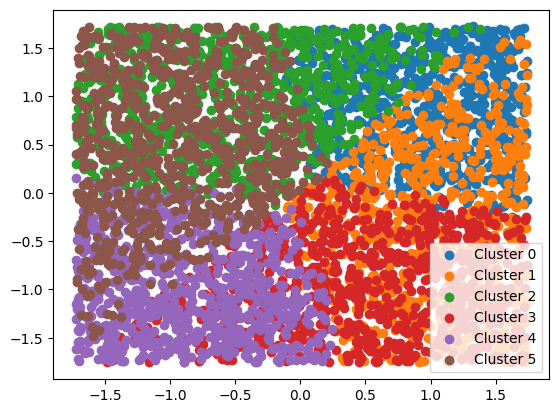

In [ ]:
#Entrenamiento del algoritmo
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 6,
    n_init = 7, #hiperparámetro
    max_iter = 600, #randomarámetro
    random_state = 123
)

kmeans.fit(df_cars2_k)
label = kmeans.predict(df_cars2_k)

#Visualizar clusters
u_labels = np.unique(kmeans.labels_)

for i in u_labels:
    cluster_data = df_cars2_k[kmeans.labels_ == i]
    plt.scatter(
        cluster_data.iloc[:, 0],
        cluster_data.iloc[:, 1],
        label=f'Cluster {i}'
    )

plt.legend()
plt.show()

**Con K  = 9**

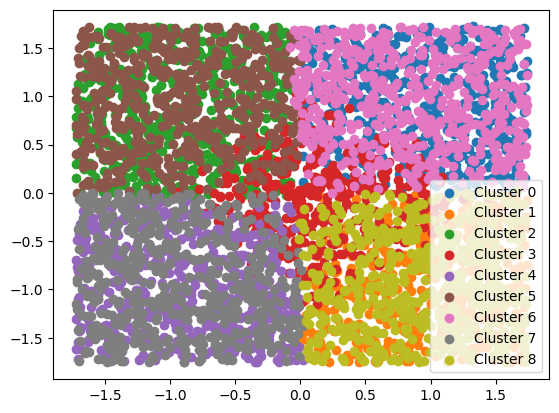

In [ ]:
#Entrenamiento del algoritmo
kmeans1 = KMeans(
    init = 'k-means++',
    n_clusters = 9,
    n_init = 7, #hiperparámetro
    max_iter = 600, #randomarámetro
    random_state = 123
)

kmeans1.fit(df_cars2_k)
label = kmeans1.predict(df_cars2_k)

#Visualizar clusters
u_labels = np.unique(kmeans1.labels_)

for i in u_labels:
    cluster_data = df_cars2_k[kmeans1.labels_ == i]
    plt.scatter(
        cluster_data.iloc[:, 0],
        cluster_data.iloc[:, 1],
        label=f'Cluster {i}'
    )

plt.legend()
plt.show()

#### Evaluación de modelo iniciales de Kmeans

In [ ]:
#K=6
inertia = kmeans.inertia_
silhouette = silhouette_score(df_cars2_k, kmeans.labels_)
calinski_score = calinski_harabasz_score(df_cars2_k, kmeans.labels_)

#K=9
inertia_1 = kmeans1.inertia_
silhouette_1 = silhouette_score(df_cars2_k, kmeans1.labels_)
calinski_score_1 = calinski_harabasz_score(df_cars2_k, kmeans1.labels_)

In [ ]:
#Comparación de modelo con 6 y 9 clusters
resultados_kmeans_inicial = pd.DataFrame([['Modelo con K=6', inertia, silhouette, calinski_score],
                                  ['Modelo con K=9', inertia_1, silhouette_1, calinski_score_1]],
                                 columns = ['Modelo KMeans', 'Inercia', 'Coeficiente de silueta', 'Calinski Score'])

resultados_kmeans_inicial

Modelo KMeans      Inercia  Coeficiente de silueta  Calinski Score
0  Modelo con K=6  4940.658771                0.289030     2033.642465
1  Modelo con K=9  3476.706623                0.292306     2067.836030

Los dos modelos iniciales presentan un mal rendimiento por varias razones:

* La inercia o la suma de cuadrados de los puntos a sus centroides más cercanos es alta, lo que podría significar que los clusters no están tan bien definidos, por el contrario, los objetos de los grupos están dispersos con respecto a su centro. En este caso al tener k=9, la agrupación es más estrecha, evidenciando un mejor modelo. Entre más baja la inercia, mejor modelo y mejor agrupación.

* El coeficiente de siluetta es muy cercano en ambos casos. Esta medida indica la similitud de un objeto con respecto a su cluster, o que tan bien encaja este en ese cluster, así como la separación entre ellos (solapamiento). Aunque el modelo con 9 agrupaciones es un poco mejor, el coeficiente de silueta es significativamente más bajo de lo esperado, que es 0,6. Hay solapamiento evidente, por ende ruido, evidenciado en las gráficas y los resultados.

* Al igual que con la anterior métrica, el score de Calinski es mejor en k = 9, pero no de manera significativa. Esta métrica mide la relación entre la dispersión dentro de los clusters, con la dispersión entre conglomerados. Valores más alto indican que los objetos están concentrados en sus cluster, en este caso sí se puede ver un score relativamente bueno.

Se tomará el modelo con 9 clusters como el inicial.

In [ ]:
# Predicción de los clusters con modelo ganador
cluster_1 = kmeans1.predict(df_cars2)
df_sample_cars_k = df_sample_cars.copy() #Copia de la base sin escalar ni transformar
df_sample_cars_k['CLUSTER_1'] = cluster_1
df_sample_cars_k.head()

Manufacturer   Model  Engine_size Fuel_type Year_manufacture  Mileage  \
33553       0.1022  0.1032     1.002951     0.249           0.0394   161838   
9427         0.107   0.101     3.361567    0.2432           0.0428     3474   
199         0.1002  0.0992     2.201474    0.2558           0.0456   129959   
12447        0.096   0.098     1.338103    0.2432           0.0466    77035   
39489       0.0914  0.0956     2.448674    0.2432           0.0432   131672   

       Price  CLUSTER_1  
33553  40533          5  
9427    2927          8  
199     9621          2  
12447   5985          4  
39489  28891          5

## Reducción de dimensionalidad PCA

In [ ]:
df_cars2_k.shape

(5000, 7)

**PCA con variables categóricas**

In [ ]:
#Explicación de un mínimo de 90% de la varianza
pca = PCA(n_components=0.90).fit(df_cars2_k) #Para mantener el 90% de la varianza se necesitan 3 componentes
pca.n_components_

3

En este caso la cantidad de componentes principales que explican el 90% de la varianza, coincide con la cantidad de variables numéricas obtenidas.

In [ ]:
#Por último, transforme "train_df1"
X_pca = pca.fit_transform(df_cars2_k)
X_pca[:3]

array([[-0.66321799,  0.9872258 , -1.95298916],
       [-0.53566755, -1.88265452,  1.30512817],
       [-1.34036243,  0.23406308,  0.30765954]])

Se puede proceder a la graficación, pues  el número de componentes principales que explican la varianza coinciden con el número de componentes máximos que se puden graficar.

In [ ]:
PCA_variance = pd.DataFrame({'Varianza explicada (%)': pca.explained_variance_ratio_ * 100})  # Almacenar varianza explicada

# Etiquetas para los componentes principales
PC_labels = ['PC ' + str(i) for i in range(1, len(PCA_variance) + 1)]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=PC_labels,
    y=PCA_variance['Varianza explicada (%)'],  # Varianza explicada
    marker_color='#4bafb8',
    opacity=0.8,
    marker_line=dict(color='black', width=1.5)))

fig.update_layout(title="Varianza explicada por cada componente principal",
    xaxis_title="Componentes principales",
    yaxis_title="Varianza explicada (%)",
    bargap=0.05,
    width=800,
    height=600)

fig.show()


In [ ]:
# --- Pesos de las variables que componen las componentes principales ---
pesos_pca = pd.DataFrame(pca.components_, columns = df_cars2_k.columns,
             index = ['PC 1', 'PC 2', 'PC 3']).round(2).T

pesos_pca

PC 1  PC 2  PC 3
Engine_size       0.69  0.12  0.71
Mileage          -0.20  0.98  0.02
Price             0.69  0.15 -0.71
Manufacturer      0.00  0.00 -0.00
Model             0.00  0.00 -0.00
Fuel_type         0.00  0.00 -0.00
Year_manufacture -0.00  0.00  0.00

**Eliminación de variables categóricas**


La reducción de la dimensionalidad confirmó la hipótesis sobre las variables categóricas y su poca o nula información aportada a los modelos. Los componentes principales en el algoritmo de KMeans muestran que los pesos de este tipo de variables son 0, en cambio las variables numéricas poseen los porcentajes totales de los pesos. Por otro lado, el análisis exploratorio evidencia que las frecuencias son uniformes, resaltando la inconsistencia existente entre los modelos de vehículos de segunda y los fabricantes enlistados. Teniendo en cuenta lo anterior, se opta por la eliminación de las variables categóricas.

In [ ]:
#Eliminación de variables categóricas
categorical_columns = df_cars2.select_dtypes(include=['object'])
df_cars2 = df_cars2.drop(categorical_columns, axis = 1)
df_cars = df_cars.drop(['Manufacturer','Model','Fuel_type', 'Year_manufacture'], axis = 1)
df_cars2_k = df_cars2_k.drop(['Manufacturer','Model','Fuel_type', 'Year_manufacture'], axis = 1)

**PCA sin variables categóricas**

In [ ]:
#Explicación de un mínimo de 90% de la varianza
pca = PCA(n_components=0.90).fit(df_cars2_k) #Para mantener el 90% de la varianza se necesitan 3 componentes
pca.n_components_

3

In [ ]:
#Por último, transforme "train_df1"
X_pca = pca.fit_transform(df_cars2_k)
X_pca[:3]

array([[-0.66321856,  0.98722478, -1.95298934],
       [-0.53566733, -1.8826539 ,  1.30512854],
       [-1.34036254,  0.23406267,  0.3076603 ]])

In [ ]:
PCA_variance = pd.DataFrame({'Varianza explicada (%)': pca.explained_variance_ratio_ * 100})  # Almacenar varianza explicada

# Etiquetas para los componentes principales
PC_labels = ['PC ' + str(i) for i in range(1, len(PCA_variance) + 1)]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=PC_labels,
    y=PCA_variance['Varianza explicada (%)'],  # Varianza explicada
    marker_color='#4bafb8',
    opacity=0.8,
    marker_line=dict(color='black', width=1.5)))

fig.update_layout(title="Varianza explicada por cada componente principal",
    xaxis_title="Componentes principales",
    yaxis_title="Varianza explicada (%)",
    bargap=0.05,
    width=800,
    height=600)

fig.show()

In [ ]:
# --- Pesos de las variables que componen las componentes principales ---
pesos_pca = pd.DataFrame(pca.components_, columns = df_cars2_k.columns,
             index = ['PC 1', 'PC 2', 'PC 3']).round(2).T

pesos_pca

PC 1  PC 2  PC 3
Engine_size  0.69  0.12  0.71
Mileage     -0.20  0.98  0.02
Price        0.69  0.15 -0.71

En el primer componente principal se evidencia que son las variables 'Engine_size' y 'Price', las que tienen mayor peso, por ende mejor contribución al componente. 'Mileage' tiene un peso inverso, es decir, mientras el % de explicación del componente aumente, el peso de la variable 'Mileage' disminuye.

Al contrario del primer componente, es el 'Mileage' la que tiene una relación mas fuerte, con mejor peso, que las otras dos variables. Esto sugiere que la variable contiene la mayor parte de la variabilidad explicada por la componente.

Para el tercer componente se evidencia una relación fuerte e inversa con 'Price', y directa con 'Engine_size', contributen de diferente manera.

In [ ]:
pca.explained_variance_ratio_

array([0.34308969, 0.33294906, 0.32396126])

Estos valores son, de manera puntual, el porcentaje de explicación de variabilidad que tiene cada uno de los componentes principales del total de conjunto de datos.

**Entrenamiento con PCA**

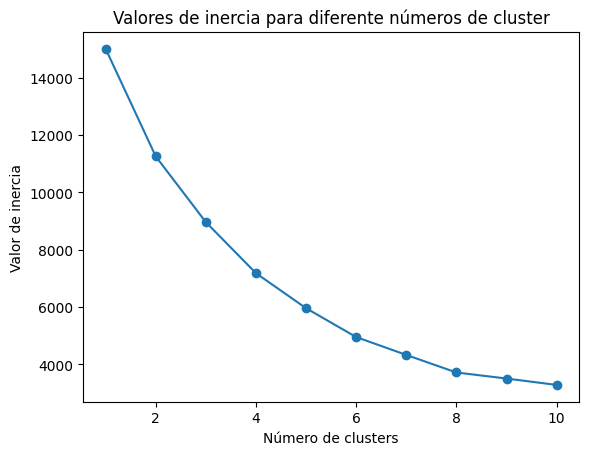

In [ ]:
# Número optimo de K
inertia_list1 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(X_pca)
    inertia_list1.append(kmeans.inertia_)

# plot the inertia curve
plt.plot(range(1,11),inertia_list1)
plt.scatter(range(1,11),inertia_list1)
plt.xlabel("Número de clusters", size=10)
plt.ylabel("Valor de inercia", size=10)
plt.title("Valores de inercia para diferente números de cluster", size=12)
plt.show()

In [ ]:
#Selección automática del punto de codo
kl = KneeLocator(
    range(2,12),
    inertia_list1,
    curve = "convex",
    direction= "decreasing"
)

print(f'El k óptimo según el punto de codo es: {kl.elbow}')

El k óptimo según el punto de codo es: 5


Para el modelo de KMeans con PCA, el número de clusters óptimo es 5, sin embargo según la gráfica se evidencia que 6 agrupaciones podría ser un K óptimo, por lo tanto se testean ambos. El modelo es entrenado con los mismos hiperparámetros encontrados para el modelo inicial.

### Entrenamiento modelos KMeans con PCA

**K = 5**

In [ ]:
#Entrenamiento del algoritmo
model_kmeans_pca = KMeans(
    init = "random",
    n_clusters = 5,
    n_init = 7, #hiperparámetro
    max_iter = 600, #Hiperparámetro
    random_state = 123
)

model_kmeans_pca.fit(X_pca)
label = model_kmeans_pca.predict(X_pca)

**k = 6**

In [ ]:
#Entrenamiento del algoritmo
model_kmeans_pca1 = KMeans(
    init = "random",
    n_clusters = 6,
    n_init = 7, #hiperparámetro
    max_iter = 600, #Hiperparámetro
    random_state = 123
)

model_kmeans_pca1.fit(X_pca)
label1 = model_kmeans_pca1.predict(X_pca)

#### Evaluación modelos KMeans con PCA

In [ ]:
# --- Evaluación del modelo kmeans con dataset reducido ---
inertia1 = model_kmeans_pca.inertia_
silhouette1 = silhouette_score(X_pca, model_kmeans_pca.labels_)
calinski_score1 = calinski_harabasz_score(X_pca, model_kmeans_pca.labels_)

inertia11 = model_kmeans_pca1.inertia_
silhouette11 = silhouette_score(X_pca, model_kmeans_pca1.labels_)
calinski_score11 = calinski_harabasz_score(X_pca, model_kmeans_pca1.labels_)

resultados_kmeans_pca = pd.DataFrame([['Modelo con k = 5', inertia1, silhouette1, calinski_score1],
                                  ['Modelo con K = 6', inertia11, silhouette11, calinski_score11]],
                                 columns = ['Modelo KMeans con PCA', 'Inercia', 'Coeficiente de silueta', 'Calinski Score'])

resultados_kmeans_pca

Modelo KMeans con PCA     Inercia  Coeficiente de silueta  Calinski Score
0      Modelo con k = 5  5945.66741                0.269919     1901.669522
1      Modelo con K = 6  4940.78643                0.288958     2033.540917

Estos modelos con reducción de dimensionalidad evidencian un coeficiente de silueta muy bajo, lo que significa que los objetos no encajan muy bien en el cluster, no hay cohesión, hay solapamiento entre ellos. En cuanto a la inercia, la distancia entre el centroide de un cluster y los puntos de este, es muy alta, por ende se encuentran muy dispersos los datos. Por último, el score de Calinski es muy bajo comparado con otros modelos, lo que da a entender que los clusters no son ni compactos ni definidos.

Aunque los valores de cada métrica son muy parecidos, se elige el modelo con 6 clusters pues es el que mejor desempeño tiene, con la inercia más disminuída, el coeficiente de silueta y el score de Calinski un poco más altos.

In [ ]:
# Predicciones de los cluster
df_sample_cars_k1 = df_sample_cars.copy()
df_sample_cars_k1 = df_sample_cars_k1.drop(['Manufacturer','Model','Fuel_type', 'Year_manufacture'], axis = 1)
df_sample_cars_k1['PCA_1'] = X_pca[:, 0]
df_sample_cars_k1['PCA_2'] = X_pca[:, 1]
df_sample_cars_k1['PCA_3'] = X_pca[:, 2]
cluster_2 = model_kmeans_pca1.predict(X_pca)
df_sample_cars_k1['CLUSTER_2'] = cluster_2
df_sample_cars_k1

Engine_size  Mileage  Price     PCA_1     PCA_2     PCA_3  CLUSTER_2
33553     1.002951   161838  40533 -0.663219  0.987225 -1.952989          5
9427      3.361567     3474   2927 -0.535667 -1.882654  1.305129          0
199       2.201474   129959   9621 -1.340363  0.234063  0.307660          2
12447     1.338103    77035   5985 -1.856403 -0.804613 -0.061435          4
39489     2.448674   131672  28891 -0.257482  0.498422 -0.498012          5
...            ...      ...    ...       ...       ...       ...        ...
39885     4.495875     2759  14236  0.701281 -1.651415  1.438919          0
17566     4.051863   119969  25562  0.585359  0.432893  0.647256          3
16062     1.331260   129637  27571 -0.987623  0.329987 -1.119097          5
48445     3.006840   142134   8359 -0.958720  0.515049  0.869367          2
20382     3.313765   112159  37312  0.740844  0.347448 -0.392959          3

[5000 rows x 7 columns]

Cada objeto es asignado a un cluster, para posteriormente ser graficados.

In [ ]:
%pip install nbformat
%pip install plotly

import plotly.express as px

# 3d scatterplot using plotly.express
df_sample_cars_k1['CLUSTER_2'] = df_sample_cars_k1['CLUSTER_2'].astype('category')
fig = px.scatter_3d(df_sample_cars_k1, x="PCA_1", y="PCA_2", z="PCA_3", color="CLUSTER_2")
fig.update_layout(width=1000, height=700)
fig.show()

Se evidencian unos clusters con solapamiento, poco definidos y objetos dispersos de sus clusters. Los conglomerados no se encuentran compactos.

## Reentrenamiento de modelo inicial sin variables categóricas

Es neceseario reentrenar el modelo ganador inicial sin las variables categóricas, pues anteriormente se evidenció la inutilidad de estas. Se predicen los clusteres y son asignados a df_sample_cars_k2. Los resultados de las métricas al reentrenar, coinciden con el modelo que fue entrenado con variables categóricas y numéricas.

In [ ]:
#Entrenamiento del algoritmo
kmeans1 = KMeans(
    init = 'k-means++',
    n_clusters = 9,
    n_init = 7, #hiperparámetro
    max_iter = 600, #randomarámetro
    random_state = 123
)

kmeans1.fit(df_cars2_k)

# Predicción de los clusters con modelo ganador
cluster_1 = kmeans1.predict(df_cars2_k)
df_sample_cars_k2 = df_sample_cars.copy() #Copia de la base sin escalar ni transformar
df_sample_cars_k2['CLUSTER_1'] = cluster_1
df_sample_cars_k2.head()

#Métricas

inertia_1 = kmeans1.inertia_
silhouette_1 = silhouette_score(df_cars2_k, kmeans1.labels_)
calinski_score_1 = calinski_harabasz_score(df_cars2_k, kmeans1.labels_)

print(f'Inercia: {inertia_1}, coeficiente de silueta: {silhouette_1}, Score de Calinski: {calinski_score_1}')

Inercia: 3476.4431956401313, coeficiente de silueta: 0.2923246501937183, Score de Calinski: 2067.9926570743955


## Comparación Kmeans con y sin PCA

In [ ]:
#Comparación de modelo sin PCA y con PCA
resultados_kmeans = pd.DataFrame([['Modelo Kmeans sin PCA k=9', inertia_1, silhouette_1, calinski_score_1],
                                  ['Modelo Kmeans sin PCA k=6', inertia, silhouette, calinski_score],
                                  ['Modelo Kmeans con PCA k=6', inertia11, silhouette11, calinski_score11]],
                                 columns = ['Modelo', 'Inercia', 'Coeficiente de silueta', 'Calinski Score'])

resultados_kmeans

Modelo      Inercia  Coeficiente de silueta  \
0  Modelo Kmeans sin PCA k=9  3476.443196                0.292325   
1  Modelo Kmeans sin PCA k=6  4940.658771                0.289030   
2  Modelo Kmeans con PCA k=6  4940.786430                0.288958   

   Calinski Score  
0     2067.992657  
1     2033.642465  
2     2033.540917

Los resultados sugieren que el modelo con mejor desempeño es aquel que no aplicó reducción de dimensionalidad mediante componentes principales (PCA) y utilizó 9 clusters, indicando que las variables originales capturaban mejor información.

Esto puede suceder debido a que las variables numéricas por sí solas eran pocas y muy significativas, por lo que intentar reducir la dimensionalidad resultó en la misma cantidad de variables como de componentes. Una evidencia de lo anterior, es que los modelos con PCA y sin PCA, utilizando la misma cantidad de clusters, arrojan valores muy similares, casi que iguales, lo que confirma la hipótesis de que las variables numéricas eran tan importantes, que la reducción de estas no eran posibles, en comparación con las variables categóricas que fueron eliminadas. Las variables numpericas originales explicaban la variabilidad mucho mejor que los componentes principales.

El modelo ganador tiene mejores métricas que los otros dos enlistados, sin embargo, el desempeño en cuanto a la definición de clusters, distancia entre centroide y objetos, solapamiento y demás, sigue siendo regular. Otro tipo de algoritmos podría adecuarse mejor a estos datos.

## Evaluación de características de cada cluster con el modelo elegido

Para evaluar las similitudes de los objetos agrupados en cada cluster, se crean gráficos de barras para cada variable. Estos contienen la media de cada característica, por cada cluster.

**Modelo inicial sin variables categóricas**

In [ ]:
#Promedio del tamaño del motor por cluster
Engine_size_var = df_sample_cars_k2[['Engine_size', 'CLUSTER_1']].groupby('CLUSTER_1').mean().reset_index()

#Promedio del precio de los vehículos por cluster
price_var = df_sample_cars_k2[['Price', 'CLUSTER_1']].groupby('CLUSTER_1').mean().reset_index()

#Promedio del Mileage por cluster
mileage_var = df_sample_cars_k2[['Mileage', 'CLUSTER_1']].groupby('CLUSTER_1').mean().reset_index()

fig = make_subplots(rows=1, cols=3, subplot_titles=("Promedio de tamaño del motor", "Promedio del precio de los vehículos", "Promedio del kilometraje"))

#Tamaño del motor
fig.add_trace(go.Bar(x=Engine_size_var['CLUSTER_1'], y=Engine_size_var['Engine_size'], name='Tamaño del Motor', marker_color='lightblue'), row=1, col=1)

#Precio del vehículo
fig.add_trace(go.Bar(x=price_var['CLUSTER_1'], y=price_var['Price'], name='Precio del Vehículo', marker_color='lightgreen'),row=1, col=2)

#Kilometraje
fig.add_trace(go.Bar(x=mileage_var['CLUSTER_1'], y=mileage_var['Mileage'], name='Kilometraje', marker_color='lightcoral'),row=1, col=3)

fig.update_layout(height=500, width=1200, title_text="Promedios por Cluster",title_x=0.5, showlegend=False)
fig.show()


Se concluye para el algoritmo de Kmeans que:

* El clúster 0 agrupa vehículos con alto kilometraje, precio y tamaño de motor. Esto podría representar un conglomerado de autos con buen rendimiento, y precio, pero que han sido muy utilizados.

* El clúster 1 se caracteriza por automóviles que tienen buen rendimiento o potencia, debido al gran tamaño del motor, por lo que su precio es alto. Este tipo no tiene un recorrido previo significativo.

* El clúster 2 y 4 representan los vehículos de segunda que tienen un tamaño de motor por encima de la media, pero un precio y kilometraje por debajo de esta. Podría encajar en un grupo de gama media-baja.

* El clúster 3 selecciona autos gamas medias, con niveles de características muy estables, un poco por encima de la media.

* El clúster 5 tiene una particularidad, pues presenta los autos con menos rendimiento y kilometraje, pero con un precio muy elevado. Podrían ser de los más costosos del mercado debido a el poco uso que tienen.

* El clúster 6, aunque tiene un recorrido más alto, su potencia y rendimiento es bueno, por un precio más asequible.

* El clúster 7 agrupa vehículos por su poco kilometraje promedio, pero con alto precio, posiblemente debido a su poco uso. No tienen el mejor rendimiento del mercado.

* Por último, el clúster 8 agrupa los mejores vehículos, pues tienen bastante potencia, han sido poco utilizados, y sus precios son de los mejores del mercado. Este grupo representa una gran oportunidad para personas con bajo presupuesto, pero con grandes expectativas en el rendimiento del vehículo.

# Aplicación algoritmo Gaussian Mixture Clustering

## GMM sin PCA


In [ ]:
df_cars2.head()

Engine_size   Mileage     Price
33553    -1.722959  1.055759  1.070245
9427      0.320578 -1.712937 -1.580431
199      -0.684542  0.498414 -1.108601
12447    -1.432579 -0.426862 -1.364886
39489    -0.470365  0.528363  0.249654

In [ ]:
df_sample_cars_gmm=df_cars2.copy()
df_sample_cars_gmm.head()

Engine_size   Mileage     Price
33553    -1.722959  1.055759  1.070245
9427      0.320578 -1.712937 -1.580431
199      -0.684542  0.498414 -1.108601
12447    -1.432579 -0.426862 -1.364886
39489    -0.470365  0.528363  0.249654

###Estimación de hiperparámetros

####Número de componentes

#####Puntaje de silueta

Se evaluará el desempeño de un modelo de clustering basado en el Gaussian Mixture Model (GMM) utilizando el puntaje de silueta. El puntaje silueta mide cuán bien agrupados están los puntos dentro de un clúster y qué tan separados están de otros clústeres

Text(0, 0.5, 'Score')

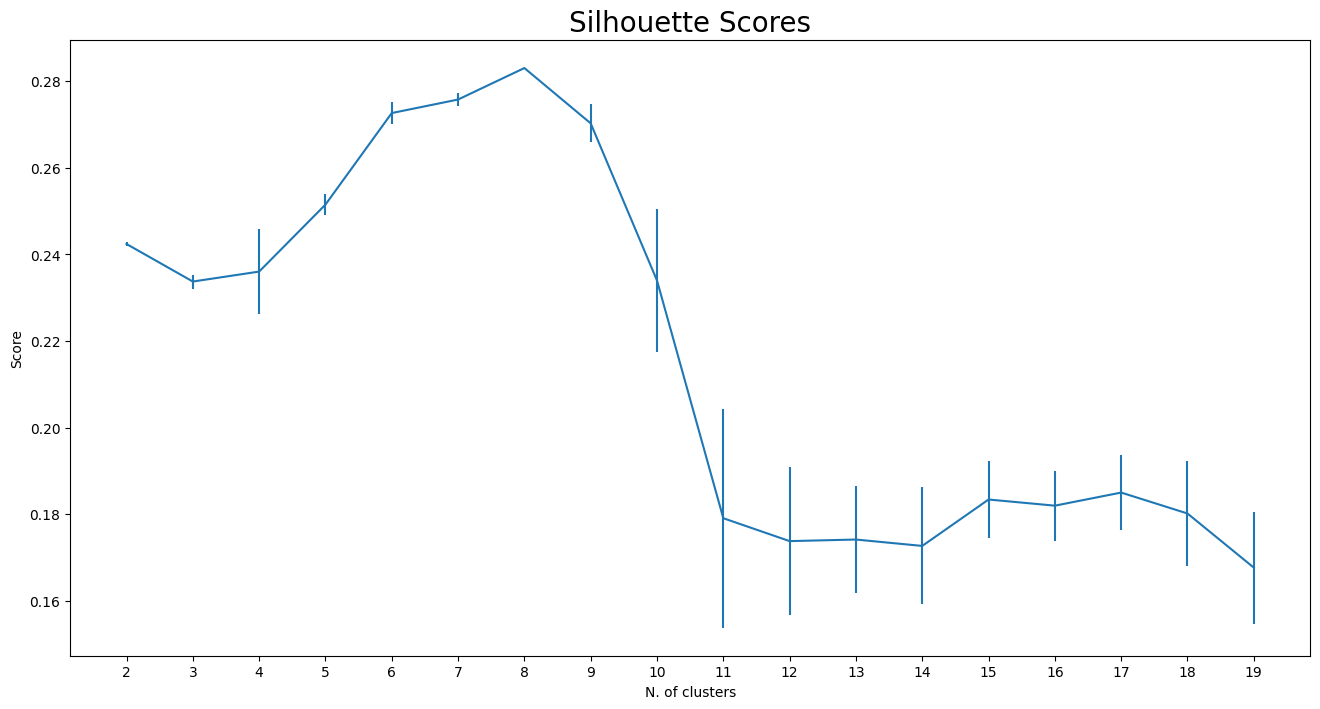

In [ ]:
rcParams['figure.figsize'] = 16, 8

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 20) #Rango de número de clústeres a probar
sils=[] #lista vacía para almacenar los resultados promedio de los puntajes silhouette
sils_err=[] #lista vacía para almacenar las desviaciones estándar promedio de los puntajes silhouette
iterations=20 #Indica cuantas veces se ejecuta el GMM para cada número de clústeres y obtener el promedio
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(df_sample_cars_gmm) #n clusteres y 2 inicializaciones
        labels=gmm.predict(df_sample_cars_gmm) #asigna cada punto a un clúster
        sil=metrics.silhouette_score(df_sample_cars_gmm, labels, metric='euclidean') #Calcula el puntaje silhouette con la métrica euclidiana
        tmp_sil.append(sil) #agrega el puntaje a la lista
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5))) #promedio de los mejores puntajes
    err=np.std(tmp_sil) #desviación estandar de los puntajes
    sils.append(val)
    sils_err.append(err)

plt.errorbar(n_clusters, sils, yerr=sils_err) #Número de clústeres que optimiza el puntaje silhouette
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

El puntaje silueta alcanza el punto máximo en el rango de 6 a 8 clústeres. A partir de 9 clústeres desciende de manera significativa y de 11 en adelante los puntajes se estabilizan en un nivel más bajo con pequeñas fluctuaciones. Un mayor puntaje indica que los puntos están mejor agupados dentro de sus clústeres y bien separados de los demás clústeres. Además, los errores son más grandes a partir de 9 clústeres, lo que sugiere mayor variabilidad en la calidad de agrupamiento con más clústeres

#####Criterio de información bayesiano (BIC)

ESe evaluará el desempeño del modelo Gaussian Mixture Model (GMM) para diferentes números de clústeres usando el Criterio de Información Bayesiano (BIC) como métrica. El BIC ayuda a seleccionar el número óptimo de clústeres penalizando la complejidad del modelo (número de parámetros) frente a su ajuste a los datos

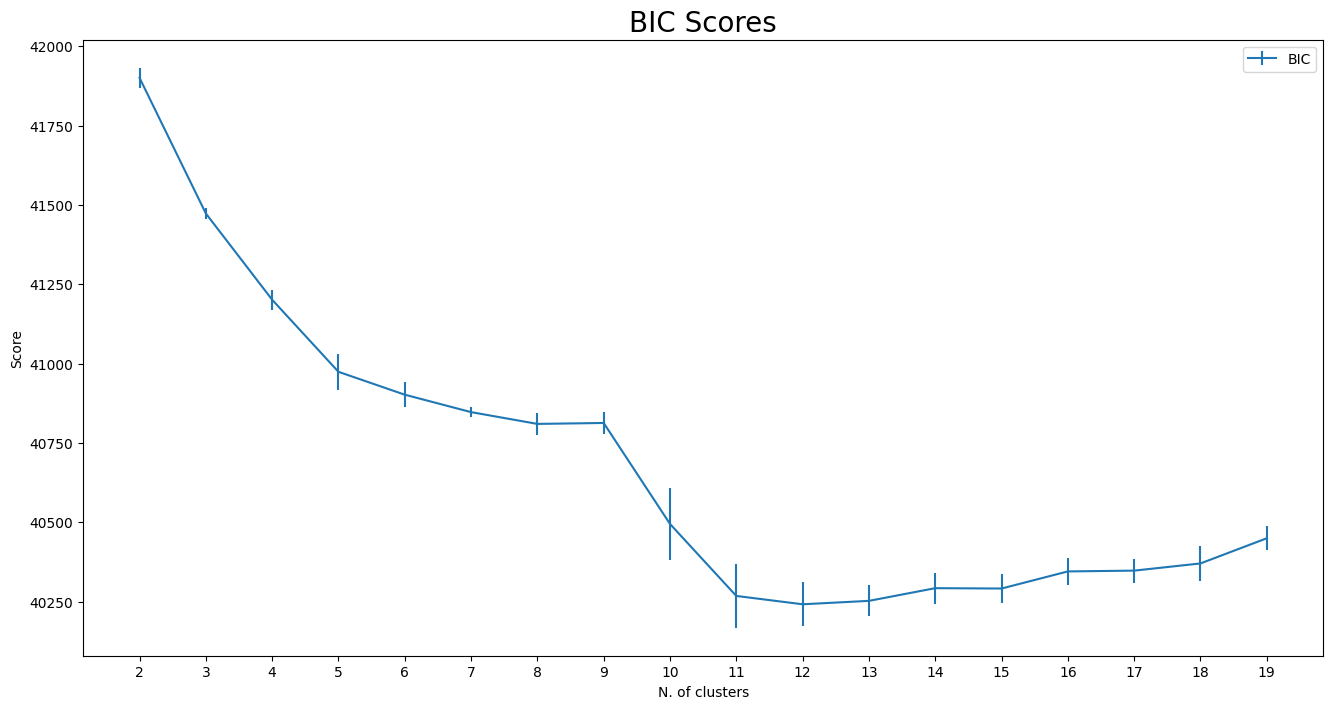

In [ ]:
n_clusters=np.arange(2, 20) #Rango de clústeres
bics=[] #Lista vacia para almacenar el valor promedio del BIC
bics_err=[] #Lista vacía para almacenar la desviación estándar del BIC para cada número de clusteres
iterations=20 #iteraciones para ajustar el modelo varias veces y obtener una estimación más precisa
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(df_sample_cars_gmm)   #ajuste de modelo con n clusteres
        tmp_bic.append(gmm.bic(df_sample_cars_gmm)) #calculo de BIC
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5))) #Selecciona las mejores X configuraciones basandose en la distancia más corta o menor error
    err=np.std(tmp_bic) #desviación estandar de las configuraciones para variabilidad de los datos
    bics.append(val) #valores promedio
    bics_err.append(err) #desviaciones

plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

Inicialmente, el BIC disminuye a medida que aumenta el número de clústeres (de 2 a 11). Esto sugiere que agregar más clústeres mejora el ajuste del modelo hasta cierto punto. A partir de 11 clústeres, los valores de BIC comienzan a estabilizarse y eventualmente aumentan ligeramente. Esto indica que agregar más clústeres no mejora significativamente el ajuste y, en algunos casos, hace que el modelo sea más complejo de lo necesario (sobreajuste).
El número de clústeres óptimo sería donde el BIC alcanza su valor más bajo. En este caso, parece estar alrededor de los 10 o 11 clústeres, aunque a partir de los 8 se evidencia un patrón de disminución en el BIC.
Las barras de error indican la variabilidad en los valores de BIC para cada número de clústeres. En este caso, las barras de error no son muy grandes, lo que sugiere que los valores de BIC son relativamente consistentes entre las distintas ejecuciones del modelo para un número dado de clústeres.

#####Resultados y decisión

In [ ]:
import pandas as pd
obj={'Metric': ['Silohuette score sin PCA', 'BIC score sin PCA'],
    "number of clusters": [6,8]}
df=pd.DataFrame(obj)
df.set_index('Metric')

number of clusters
Metric                                      
Silohuette score sin PCA                   6
BIC score sin PCA                          8

###Otros hiperparámetros

Se ajustarán los hiperparámetros de tipo de covarianza, maximas iteraciones y número de inicializaciones para cada número de componente previamente elegido

####Con n_components de 6

In [ ]:
#valores de los hiperparámetros
parametros = {
    'n_components': [6],  # Número de clusters
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipos de covarianza
    'max_iter': [100, 200, 300],  # Número máximo de iteraciones
    'n_init': [1, 5, 10]  # Inicializaciones
}

#almacenar modelo con su respectivo bic
mejor_bic = np.inf
mejor_modelo = None
mejores_parametros = None

#Buscar hiperparámetros
for n_components in parametros['n_components']:
    for covariance_type in parametros['covariance_type']:
        for max_iter in parametros['max_iter']:
            for n_init in parametros['n_init']:
                #Entrenamiento de modelo
                gmm = GMM(n_components=n_components, covariance_type=covariance_type,
                                      max_iter=max_iter, n_init=n_init, random_state=123)
                gmm.fit(df_sample_cars_gmm)
                #BIC
                bic_actual = gmm.bic(df_sample_cars_gmm)
                #Mejor modelo basado en el BIC más bajo
                if bic_actual < mejor_bic:
                    mejor_bic = bic_actual
                    mejor_modelo = gmm
                    mejores_parametros = {
                        'n_components': n_components,
                        'covariance_type': covariance_type,
                        'max_iter': max_iter,
                        'n_init': n_init
                    }

# Mostrar los mejores hiperparámetros y el mejor BIC
print(f'Mejor BIC: {mejor_bic}')
print(f'Mejores hiperparámetros: {mejores_parametros}')

Mejor BIC: 40744.898441308804
Mejores hiperparámetros: {'n_components': 6, 'covariance_type': 'diag', 'max_iter': 100, 'n_init': 10}


####Con n_components de 8

In [ ]:
#valores de los hiperparámetros
parametros = {
    'n_components': [8],  # Número de clusters
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipos de covarianza
    'max_iter': [100, 200, 300],  # Número máximo de iteraciones
    'n_init': [1, 5, 10]  # Inicializaciones
}

#almacenar modelo con su respectivo bic
mejor_bic = np.inf
mejor_modelo = None
mejores_parametros = None

#Buscar hiperparámetros
for n_components in parametros['n_components']:
    for covariance_type in parametros['covariance_type']:
        for max_iter in parametros['max_iter']:
            for n_init in parametros['n_init']:
                #Entrenamiento de modelo
                gmm = GMM(n_components=n_components, covariance_type=covariance_type,
                                      max_iter=max_iter, n_init=n_init, random_state=123)
                gmm.fit(df_sample_cars_gmm)
                #BIC
                bic_actual = gmm.bic(df_sample_cars_gmm)
                #Mejor modelo basado en el BIC más bajo
                if bic_actual < mejor_bic:
                    mejor_bic = bic_actual
                    mejor_modelo = gmm
                    mejores_parametros = {
                        'n_components': n_components,
                        'covariance_type': covariance_type,
                        'max_iter': max_iter,
                        'n_init': n_init
                    }

# Mostrar los mejores hiperparámetros y el mejor BIC
print(f'Mejor BIC: {mejor_bic}')
print(f'Mejores hiperparámetros: {mejores_parametros}')

Mejor BIC: 40544.55028479884
Mejores hiperparámetros: {'n_components': 8, 'covariance_type': 'tied', 'max_iter': 100, 'n_init': 5}


###Aplicación de modelo

In [ ]:
model_gmm_6=GMM(n_components=6, random_state=123, covariance_type='diag',max_iter=100, n_init=10).fit(df_sample_cars_gmm)

In [ ]:
labels_=model_gmm_6.predict(df_sample_cars_gmm)
silhouette_6=silhouette_score(df_sample_cars_gmm,labels_)
calinski_score_6=calinski_harabasz_score(df_sample_cars_gmm,labels_)
print('### DBSCAN ###')
print('Silhouette Score',silhouette_6) #mayor mejor, medida de cohesion de los clusters, >0.5
print('Calinski harabasz score',calinski_score_6) #mayor mejor, los puntos entre los cluster son cercanos y entre clusteres hay una buena separación

### DBSCAN ###
Silhouette Score 0.2701667817377493
Calinski harabasz score 1898.7524907344625


In [ ]:
model_gmm_8=GMM(n_components=8, random_state=123, covariance_type='tied',max_iter=100,n_init=5).fit(df_sample_cars_gmm)

In [ ]:
labels_=model_gmm_8.predict(df_sample_cars_gmm)
silhouette_8=silhouette_score(df_sample_cars_gmm,labels_)
calinski_score_8=calinski_harabasz_score(df_sample_cars_gmm,labels_)
print('### DBSCAN ###')
print('Silhouette Score', silhouette_8) #mayor mejor, medida de cohesion de los clusters, >0.5
print('Calinski harabasz score', calinski_score_8) #mayor mejor, los puntos entre los cluster son cercanos y entre clusteres hay una buena separación

### DBSCAN ###
Silhouette Score 0.28307329186827646
Calinski harabasz score 2158.756009069764


In [ ]:
#Comparación de modelos con 6 y 8 clusters
resultados_gmm = pd.DataFrame([
    ['Modelo gmm con 6 clústers sin PCA', silhouette_6, calinski_score_6],
    ['Modelo gmm con 8 clústers sin PCA', silhouette_8, calinski_score_8]],
    columns = ['Modelo', 'Coeficiente de silueta', 'Calinski Score'])

resultados_gmm

Modelo  Coeficiente de silueta  Calinski Score
0  Modelo gmm con 6 clústers sin PCA                0.270167     1898.752491
1  Modelo gmm con 8 clústers sin PCA                0.283073     2158.756009

##GMM con PCA

In [ ]:
df_cars_gmm_pca = df_sample_cars_gmm.copy()
#.drop(['Manufacturer','Model','Fuel_type','Year_manufacture'],axis=1)

#PCA sobre el dataset filtrado con variables numericas
pca_gmm=PCA(n_components=3).fit(df_cars_gmm_pca)
x_pca_gmm=pca_gmm.fit_transform(df_cars_gmm_pca)

###Estimación de hiperparámetros

####Número de componentes

#####Puntaje de silueta

Text(0, 0.5, 'Score')

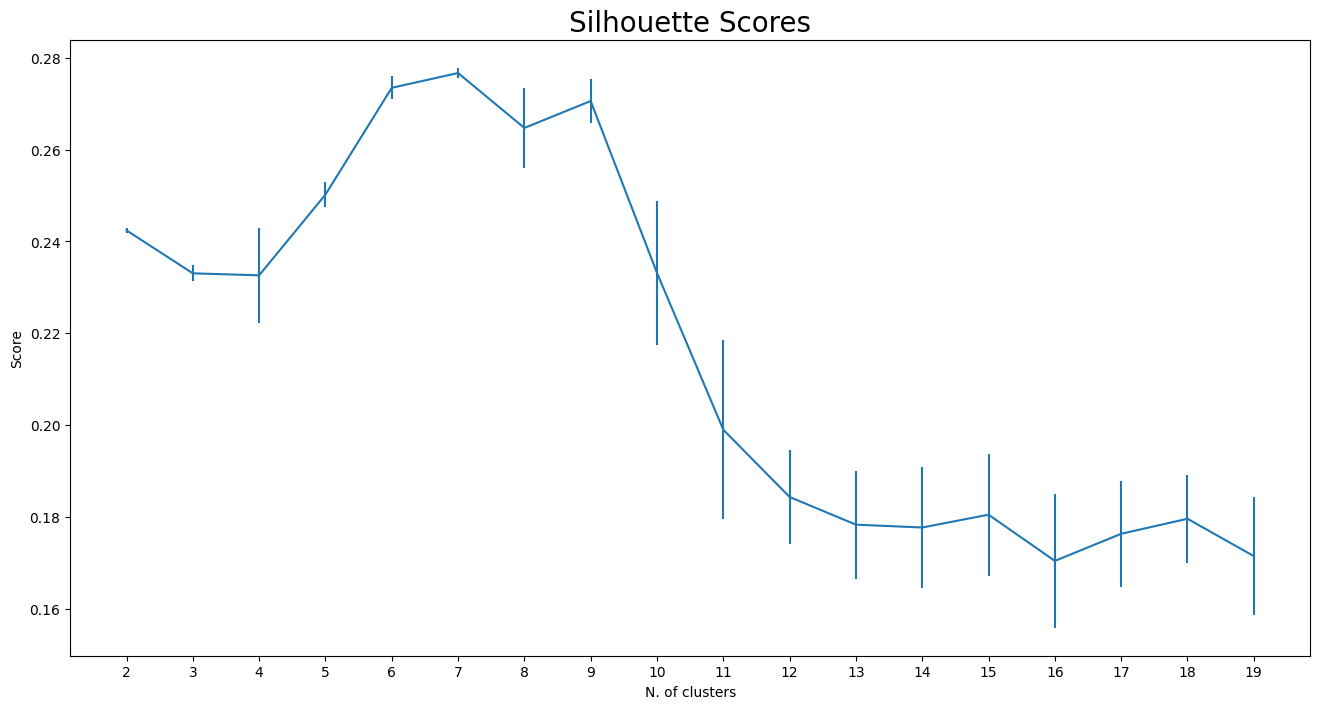

In [ ]:
rcParams['figure.figsize'] = 16, 8

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 20) #Rango de número de clústeres a probar
sils=[] #lista vacía para almacenar los resultados promedio de los puntajes silhouette
sils_err=[] #lista vacía para almacenar las desviaciones estándar promedio de los puntajes silhouette
iterations=20 #Indica cuantas veces se ejecuta el GMM para cada número de clústeres y obtener el promedio
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(x_pca_gmm) #n clusteres y 2 inicializaciones
        labels=gmm.predict(x_pca_gmm) #asigna cada punto a un clúster
        sil=metrics.silhouette_score(x_pca_gmm, labels, metric='euclidean') #Calcula el puntaje silhouette con la métrica euclidiana
        tmp_sil.append(sil) #agrega el puntaje a la lista
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5))) #promedio de los mejores puntajes
    err=np.std(tmp_sil) #desviación estandar de los puntajes
    sils.append(val)
    sils_err.append(err)

plt.errorbar(n_clusters, sils, yerr=sils_err) #Número de clústeres que optimiza el puntaje silhouette
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

#####Criterio de información bayesiano (BIC)

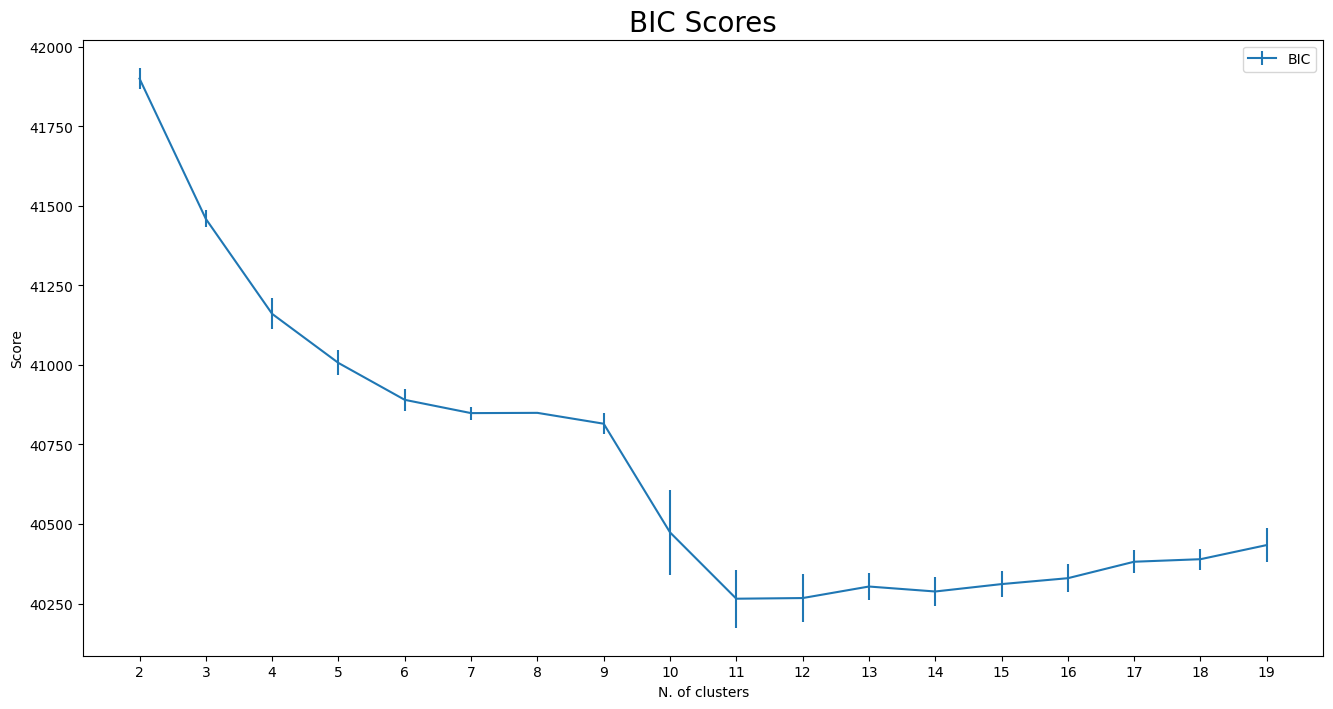

In [ ]:
n_clusters=np.arange(2, 20) #Rango de clústeres
bics=[] #Lista vacia para almacenar el valor promedio del BIC
bics_err=[] #Lista vacía para almacenar la desviación estándar del BIC para cada número de clusteres
iterations=20 #iteraciones para ajustar el modelo varias veces y obtener una estimación más precisa
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(x_pca_gmm)   #ajuste de modelo con n clusteres
        tmp_bic.append(gmm.bic(x_pca_gmm)) #calculo de BIC
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5))) #Selecciona las mejores X configuraciones basandose en la distancia más corta o menor error
    err=np.std(tmp_bic) #desviación estandar de las configuraciones para variabilidad de los datos
    bics.append(val) #valores promedio
    bics_err.append(err) #desviaciones

plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

#####Resultados y decisión

In [ ]:
import pandas as pd
obj={'Metric': ['Silohuette score con PCA', 'BIC score sin PCA'],
    "number of clusters": [6,8]}
df=pd.DataFrame(obj)
df.set_index('Metric')

number of clusters
Metric                                      
Silohuette score con PCA                   6
BIC score sin PCA                          8

Los puntajes de silueta se maximizan en el mismo punto tanto para los modelos sin PCA como para los modelos sin PCA, por su lado, el BIC tambien se minimiza en el mismo punto para ambos modelos. Por esto, se elige el mismo número de clusters para ambos y se sospecha que el PCA no es influyente en este caso. Posteriormente, se entrenarán 4 modelos: uno con 6 clusters sin PCA, uno con 8 clusters sin PCA, uno con 6 clusters con PCA y uno con 8 clusters con PCA. Seguido a esto se elegirá el mejor modelo con ayuda de las métricas de puntaje de silueta y calinski harabasz

###Otros hiperparámetros

Se ajustarán los hiperparámetros de tipo de covarianza, maximas iteraciones y número de inicializaciones para cada número de componente previamente elegido y para cada modelo

####Con n_components de 6

In [ ]:
#valores de los hiperparámetros
parametros = {
    'n_components': [6],  # Número de clusters
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipos de covarianza
    'max_iter': [100, 200, 300],  # Número máximo de iteraciones
    'n_init': [1, 5, 10]  # Inicializaciones
}

#almacenar modelo con su respectivo bic
mejor_bic = np.inf
mejor_modelo = None
mejores_parametros = None

#Buscar hiperparámetros
for n_components in parametros['n_components']:
    for covariance_type in parametros['covariance_type']:
        for max_iter in parametros['max_iter']:
            for n_init in parametros['n_init']:
                #Entrenamiento de modelo
                gmm = GMM(n_components=n_components, covariance_type=covariance_type,
                                      max_iter=max_iter, n_init=n_init, random_state=123)
                gmm.fit(x_pca_gmm)
                #BIC
                bic_actual = gmm.bic(x_pca_gmm)
                #Mejor modelo basado en el BIC más bajo
                if bic_actual < mejor_bic:
                    mejor_bic = bic_actual
                    mejor_modelo = gmm
                    mejores_parametros = {
                        'n_components': n_components,
                        'covariance_type': covariance_type,
                        'max_iter': max_iter,
                        'n_init': n_init
                    }

# Mostrar los mejores hiperparámetros y el mejor BIC
print(f'Mejor BIC: {mejor_bic}')
print(f'Mejores hiperparámetros: {mejores_parametros}')


Mejor BIC: 40873.282850642754
Mejores hiperparámetros: {'n_components': 6, 'covariance_type': 'diag', 'max_iter': 100, 'n_init': 10}


####Con n_components de 8

In [ ]:
#valores de los hiperparámetros
parametros = {
    'n_components': [8],  # Número de clusters
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipos de covarianza
    'max_iter': [100, 200, 300],  # Número máximo de iteraciones
    'n_init': [1, 5, 10]  # Inicializaciones
}

#almacenar modelo con su respectivo bic
mejor_bic = np.inf
mejor_modelo = None
mejores_parametros = None

#Buscar hiperparámetros
for n_components in parametros['n_components']:
    for covariance_type in parametros['covariance_type']:
        for max_iter in parametros['max_iter']:
            for n_init in parametros['n_init']:
                #Entrenamiento de modelo
                gmm = GMM(n_components=n_components, covariance_type=covariance_type,
                                      max_iter=max_iter, n_init=n_init, random_state=123)
                gmm.fit(x_pca_gmm)
                #BIC
                bic_actual = gmm.bic(x_pca_gmm)
                #Mejor modelo basado en el BIC más bajo
                if bic_actual < mejor_bic:
                    mejor_bic = bic_actual
                    mejor_modelo = gmm
                    mejores_parametros = {
                        'n_components': n_components,
                        'covariance_type': covariance_type,
                        'max_iter': max_iter,
                        'n_init': n_init
                    }

# Mostrar los mejores hiperparámetros y el mejor BIC
print(f'Mejor BIC: {mejor_bic}')
print(f'Mejores hiperparámetros: {mejores_parametros}')

Mejor BIC: 40544.55028479884
Mejores hiperparámetros: {'n_components': 8, 'covariance_type': 'tied', 'max_iter': 100, 'n_init': 5}


Las optimización de los hiperparámetros dió como resultado diferentes valores según el número de componentes (6 y 8) pero los mismos valores para ambos dataset (con PCA y sin PCA). Por lo tanto, los modelos se entrenarán con los mismos hiperparámetros para cada número de componente, solo se hará la distinción entre el modelo sin PCA y el modelo con PCA.

###Aplicación de modelo


In [ ]:
model_gmm_pca_6=GMM(n_components=6, random_state=123, covariance_type='diag',max_iter=100, n_init=10).fit(x_pca_gmm)

In [ ]:
labels_=model_gmm_pca_6.predict(x_pca_gmm)
silhouette_pca_6=silhouette_score(x_pca_gmm,labels_)
calinski_score_pca_6=calinski_harabasz_score(x_pca_gmm,labels_)
print('### DBSCAN ###')
print('Silhouette Score',silhouette_pca_6) #mayor mejor, medida de cohesion de los clusters, >0.5
print('Calinski harabasz score',calinski_score_pca_6) #mayor mejor, los puntos entre los cluster son cercanos y entre clusteres hay una buena separación

### DBSCAN ###
Silhouette Score 0.27329140870200225
Calinski harabasz score 1913.9869424427695


In [ ]:
model_gmm_pca_8=GMM(n_components=8, random_state=123, covariance_type='tied',max_iter=100,n_init=5).fit(x_pca_gmm)

In [ ]:
labels_=model_gmm_pca_8.predict(x_pca_gmm)
silhouette_pca_8=silhouette_score(x_pca_gmm,labels_)
calinski_score_pca_8=calinski_harabasz_score(x_pca_gmm,labels_)
print('### DBSCAN ###')
print('Silhouette Score', silhouette_pca_8) #mayor mejor, medida de cohesion de los clusters, >0.5
print('Calinski harabasz score', calinski_score_pca_8) #mayor mejor, los puntos entre los cluster son cercanos y entre clusteres hay una buena separación

### DBSCAN ###
Silhouette Score 0.28307329186827646
Calinski harabasz score 2158.7560090697634


##Comparación de los modelos

In [ ]:
#Comparación de modelos con 6 y 8 clusters
resultados_gmm = pd.DataFrame([
    ['Modelo gmm con 6 clústers sin PCA', silhouette_6, calinski_score_6],
    ['Modelo gmm con 6 clústers con PCA', silhouette_pca_6, calinski_score_pca_6],
    ['Modelo gmm con 8 clústers sin PCA', silhouette_8, calinski_score_8],
    ['Modelo gmm con 8 clústers con PCA', silhouette_pca_8, calinski_score_pca_8]],
    columns = ['Modelo', 'Coeficiente de silueta', 'Calinski Score'])

resultados_gmm

Modelo  Coeficiente de silueta  Calinski Score
0  Modelo gmm con 6 clústers sin PCA                0.270167     1898.752491
1  Modelo gmm con 6 clústers con PCA                0.273291     1913.986942
2  Modelo gmm con 8 clústers sin PCA                0.283073     2158.756009
3  Modelo gmm con 8 clústers con PCA                0.283073     2158.756009

El mejor modelo de mezclas gaussianas con 6 clusters fue el modelo con PCA mientras que los modelos con 8 clusteres tanto con PCA como sin PCA tuvieron los mismos puntajes. Entre el modelo con 6 y con 8 clusters, fue mejor el de 8. Por lo tanto, este quedará definido como el mejor modelo de mezclas gaussianas y ya que los resultados fueron los mismos con PCA y sin PCA se considera que no es significativa la implementación de reducción de la dimensionalidad en este caso.

##Visualización de los modelos

In [ ]:
df_visual_gmm=df_sample_cars.copy()
df_visual_gmm

Manufacturer   Model  Engine_size Fuel_type Year_manufacture  Mileage  \
33553       0.1022  0.1032     1.002951     0.249           0.0394   161838   
9427         0.107   0.101     3.361567    0.2432           0.0428     3474   
199         0.1002  0.0992     2.201474    0.2558           0.0456   129959   
12447        0.096   0.098     1.338103    0.2432           0.0466    77035   
39489       0.0914  0.0956     2.448674    0.2432           0.0432   131672   
...            ...     ...          ...       ...              ...      ...   
39885       0.1018  0.1034     4.495875     0.252           0.0416     2759   
17566        0.107  0.0994     4.051863    0.2432           0.0428   119969   
16062       0.1022  0.0996     1.331260    0.2432            0.044   129637   
48445        0.099  0.1034     3.006840    0.2432           0.0474   142134   
20382       0.1012  0.1046     3.313765     0.249            0.044   112159   

       Price  
33553  40533  
9427    2927  
199     9621  
12447   5985  
39489  28891  
...      ...  
39885  14236  
17566  25562  
16062  27571  
48445   8359  
20382  37312  

[5000 rows x 7 columns]

###Modelo gmm con 6 clústers sin PCA

In [ ]:
cluster_1=model_gmm_6.predict(df_sample_cars_gmm)
df_visual_gmm['CLUSTER_1']=cluster_1

In [ ]:
# 3d scatterplot using plotly.express
df_visual_gmm['CLUSTER_1'] = df_visual_gmm['CLUSTER_1'].astype('category')
fig = px.scatter_3d(df_visual_gmm, x='Engine_size', y='Mileage', z='Price', color="CLUSTER_1")
fig.update_layout(width=800, height=700,
                  legend=dict(x=0.15,  # Mueve la leyenda más hacia la izquierda
                              y=0.5,  # Ajusta la posición vertical, 0.5 es el centro
                              xanchor='right',  # Ancla la leyenda desde la izquierda
                              yanchor='middle',  # Ancla la leyenda verticalmente desde el centro
    ))
fig.show()

###Modelo gmm con 6 clústers con PCA

In [ ]:
df_visual_gmm['PCA_1'] = x_pca_gmm[:, 0]
df_visual_gmm['PCA_2'] = x_pca_gmm[:, 1]
df_visual_gmm['PCA_3'] = x_pca_gmm[:, 2]
cluster_2 = model_gmm_pca_6.predict(x_pca_gmm)
df_visual_gmm['CLUSTER_2'] = cluster_2
df_visual_gmm.head(3)

Manufacturer   Model  Engine_size Fuel_type Year_manufacture  Mileage  \
33553       0.1022  0.1032     1.002951     0.249           0.0394   161838   
9427         0.107   0.101     3.361567    0.2432           0.0428     3474   
199         0.1002  0.0992     2.201474    0.2558           0.0456   129959   

       Price CLUSTER_1     PCA_1     PCA_2     PCA_3  CLUSTER_2  
33553  40533         4 -0.663219  0.987225 -1.952989          1  
9427    2927         5 -0.535667 -1.882654  1.305129          3  
199     9621         2 -1.340363  0.234063  0.307660          0

In [ ]:
# 3d scatterplot using plotly.express
df_visual_gmm['CLUSTER_2'] = df_visual_gmm['CLUSTER_2'].astype('category')
fig = px.scatter_3d(df_visual_gmm, x='PCA_1', y='PCA_2', z='PCA_3', color="CLUSTER_2")
fig.update_layout(width=1000, height=700,
                  legend=dict(x=0.15,  # Mueve la leyenda más hacia la izquierda
                              y=0.5,  # Ajusta la posición vertical, 0.5 es el centro
                              xanchor='right',  # Ancla la leyenda desde la izquierda
                              yanchor='middle',  # Ancla la leyenda verticalmente desde el centro
    ))
fig.show()

###Modelo gmm con 8 clústers con PCA

In [ ]:
cluster_3= model_gmm_pca_8.predict(x_pca_gmm)
df_visual_gmm['CLUSTER_3'] = cluster_3
df_visual_gmm.head(3)

Manufacturer   Model  Engine_size Fuel_type Year_manufacture  Mileage  \
33553       0.1022  0.1032     1.002951     0.249           0.0394   161838   
9427         0.107   0.101     3.361567    0.2432           0.0428     3474   
199         0.1002  0.0992     2.201474    0.2558           0.0456   129959   

       Price CLUSTER_1     PCA_1     PCA_2     PCA_3 CLUSTER_2  CLUSTER_3  
33553  40533         4 -0.663219  0.987225 -1.952989         1          3  
9427    2927         5 -0.535667 -1.882654  1.305129         3          7  
199     9621         2 -1.340363  0.234063  0.307660         0          0

In [ ]:
# 3d scatterplot using plotly.express
df_visual_gmm['CLUSTER_3'] = df_visual_gmm['CLUSTER_3'].astype('category')
fig = px.scatter_3d(df_visual_gmm, x='PCA_1', y='PCA_2', z='PCA_3', color="CLUSTER_3")
fig.update_layout(width=1000, height=700,
                  legend=dict(x=0.15,  # Mueve la leyenda más hacia la izquierda
                              y=0.5,  # Ajusta la posición vertical, 0.5 es el centro
                              xanchor='right',  # Ancla la leyenda desde la izquierda
                              yanchor='middle',  # Ancla la leyenda verticalmente desde el centro
    ))
fig.show()

###Modelo gmm con 8 clústers sin PCA (Mejor modelo)

In [ ]:
cluster_4=model_gmm_8.predict(df_sample_cars_gmm)
df_visual_gmm['CLUSTER_4']=cluster_4
df_visual_gmm.head(3)

Manufacturer   Model  Engine_size Fuel_type Year_manufacture  Mileage  \
33553       0.1022  0.1032     1.002951     0.249           0.0394   161838   
9427         0.107   0.101     3.361567    0.2432           0.0428     3474   
199         0.1002  0.0992     2.201474    0.2558           0.0456   129959   

       Price CLUSTER_1     PCA_1     PCA_2     PCA_3 CLUSTER_2 CLUSTER_3  \
33553  40533         4 -0.663219  0.987225 -1.952989         1         3   
9427    2927         5 -0.535667 -1.882654  1.305129         3         7   
199     9621         2 -1.340363  0.234063  0.307660         0         0   

       CLUSTER_4  
33553          3  
9427           7  
199            0

In [ ]:
# 3d scatterplot using plotly.express
df_visual_gmm['CLUSTER_4'] = df_visual_gmm['CLUSTER_4'].astype('category')
fig = px.scatter_3d(df_visual_gmm, x='Engine_size', y='Mileage', z='Price', color="CLUSTER_4")
fig.update_layout(width=1000, height=700,
                  legend=dict(x=0.15,  # Mueve la leyenda más hacia la izquierda
                              y=0.5,  # Ajusta la posición vertical, 0.5 es el centro
                              xanchor='right',  # Ancla la leyenda desde la izquierda
                              yanchor='middle',  # Ancla la leyenda verticalmente desde el centro
    ))
fig.show()

In [ ]:
#Promedio del tamaño del motor por cluster
Engine_size_var = df_visual_gmm[['Engine_size', 'CLUSTER_4']].groupby('CLUSTER_4').mean().reset_index()

#Promedio del precio de los vehículos por cluster
price_var = df_visual_gmm[['Price', 'CLUSTER_4']].groupby('CLUSTER_4').mean().reset_index()

#Promedio del Mileage por cluster
mileage_var = df_visual_gmm[['Mileage', 'CLUSTER_4']].groupby('CLUSTER_4').mean().reset_index()

fig = make_subplots(rows=1, cols=3, subplot_titles=("Promedio de tamaño del motor", "Promedio del precio de los vehículos", "Promedio del kilometraje"))

#Tamaño del motor
fig.add_trace(go.Bar(x=Engine_size_var['CLUSTER_4'], y=Engine_size_var['Engine_size'], name='Tamaño del Motor', marker_color='lightblue'), row=1, col=1)

#Precio del vehículo
fig.add_trace(go.Bar(x=price_var['CLUSTER_4'], y=price_var['Price'], name='Precio del Vehículo', marker_color='lightgreen'),row=1, col=2)

#Kilometraje
fig.add_trace(go.Bar(x=mileage_var['CLUSTER_4'], y=mileage_var['Mileage'], name='Kilometraje', marker_color='lightcoral'),row=1, col=3)

fig.update_layout(height=500, width=1200, title_text="Promedios por Cluster",title_x=0.5, showlegend=False)
fig.show()


<ipython-input-94-fdbdc3906659>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-94-fdbdc3906659>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-94-fdbdc3906659>:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Se concluye para el algoritmo de mezclas gaussianas que:

* El clúster 0 agrupa vehículos con tamaño del motor y precio bajos pero con kilometrajes altos. Esto podría representar un conglomerado de autos utilizados en exceso, donde el bajo precio compensa el alto desgaste.

* El clúster 1 se caracteriza por automóviles que tienen buen rendimiento o potencia, debido al gran tamaño del motor, por lo que su precio es alto. Este tipo no tiene un alto recorrido. Estos autos probablemente representan opciones más premium, ideales para quienes buscan potencia y durabilidad.

* El clúster 2 tiene una particularidad, pues presenta los autos con bajo rendimiento y kilometraje, pero con un precio muy elevado. Podrían ser modelos de alta gama, apreciados por su estado casi nuevo y exclusividad.

* El clúster 3 selecciona autos con precios y kilometrajes altos pero con tamaños de motor bajos. Esto podría representar autos de gama media-alta, muy utilizados (por ejemplo, autos familiares o comerciales) que, a pesar de su alto kilometraje, mantienen un valor de mercado elevado debido a su confiabilidad o características de marca.

* El clúster 4 representa autos de gama baja, debido a que sus caracteristicas se encuentran por debajo de la media. Representan opciones accesibles, ideales para quienes buscan un auto barato, con poco uso y características básicas.

* El clúster 5 agrupa autos competitivos en el mercado, debido a que tienen un tamaño de motor alto, pero precio bajo, por lo tanto son autos de alto recorrido. Representan autos usados intensivamente (posiblemente comerciales o todoterreno), donde el bajo precio es atractivo para quienes buscan potencia a un costo accesible, a pesar del desgaste.

* El clúster 6, tiene autos con recorridos, potencia y rendimientos altos, por lo que pueden ser autos bien posicionados en el mercado.

* Por último, el clúster 7 agrupa los mejores vehículos son autos con motores grandes, poco kilometraje y precios relativamente bajos, lo que los convierte en una excelente opción para compradores que buscan rendimiento sin pagar precios premium.

# Aplicación algoritmo Hierarchical Clustering

## **Selección de la muestra**

In [ ]:
#Eliminación de variables categóricas
categorical_columns = df_cars.select_dtypes(include=['object'])
df_cars = df_cars.drop(categorical_columns, axis = 1)

In [ ]:
#Sample data frame
df_sample_cars = df_cars.sample(n=5000, random_state=42)
df_sample_cars.shape


(5000, 3)

In [ ]:
"""#Escalado de variables numéricas"""

# Identificamos las variables numéricas en el DataFrame
numerical_columns = df_sample_cars.select_dtypes(include=['float64', 'int64']).columns

# Aplicamos StandardScaler a las variables numéricas
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(df_sample_cars[numerical_columns])

# Creamos un nuevo DataFrame con las variables numéricas escaladas y los mismos índices
df_scaled_numerical = pd.DataFrame(scaled_numerical_data, columns=numerical_columns, index=df_sample_cars.index)

# Concatenamos las variables escaladas con las variables categóricas sin perder los índices
df_cars2 = pd.concat([df_scaled_numerical, df_sample_cars.drop(numerical_columns, axis=1)], axis=1)

# Mostramos las primeras filas del nuevo DataFrame
df_cars2

Engine_size   Mileage     Price
33553    -1.722959  1.055759  1.070245
9427      0.320578 -1.712937 -1.580431
199      -0.684542  0.498414 -1.108601
12447    -1.432579 -0.426862 -1.364886
39489    -0.470365  0.528363  0.249654
...            ...       ...       ...
39885     1.303358 -1.725437 -0.783311
17566     0.918661  0.323758  0.015007
16062    -1.438508  0.492785  0.156613
48445     0.013238  0.711271 -1.197554
20382     0.279162  0.187215  0.843212

[5000 rows x 3 columns]

In [ ]:
df_cars_HC = df_cars2.copy()

## **Dendograma**

Por motivos de complejidad computacional se decidió no graficar el dendograma con con los 5000 datos, y se optó por tomar una muestra de 40 datos, donde se pudiese observar el comportamiento general de los clusters.


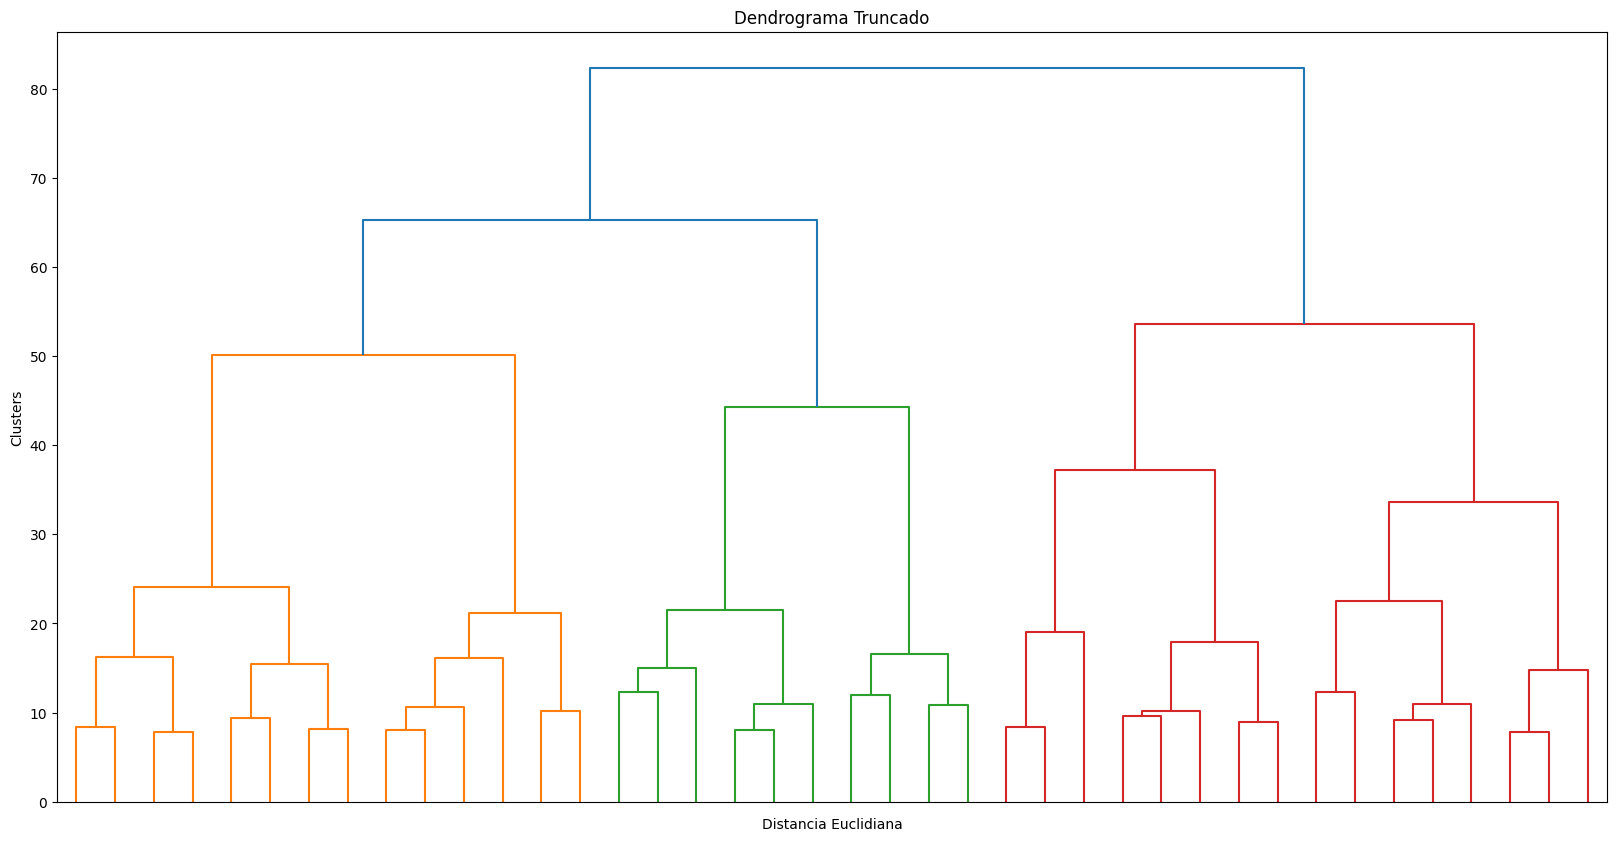

In [ ]:
df_cars_HC_numeric = df_cars_HC.select_dtypes(include=[np.number])

# Función de vinculación para agrupar los datos según similitud
Z = linkage(df_cars_HC_numeric, method='ward')

# Gráfica del dendrograma (truncada para mostrar solo una parte)
plt.figure(figsize=(20, 10))  # Ajusta el tamaño de la figura

dendrogram(
    Z,
    truncate_mode='lastp',  # Truncar el dendrograma
    p=40,  # Número de grupos finales a mostrar (ajusta según lo que desees)
    leaf_rotation=30,  # Rotación de las etiquetas de las hojas
    distance_sort='descending',  # Ordenar según la distancia
    show_leaf_counts=False,  # No mostrar la cuenta de hojas
    leaf_font_size=14  # Tamaño de fuente de las hojas
)

plt.title('Dendrograma Truncado')
plt.xlabel('Distancia Euclidiana')
plt.ylabel('Clusters')
plt.show()


Trazando una linea horizontal en el punto medio del gráfico, se pasa por aproximadamente de 5 a 6 lineas que representan una posible cantidad de clusters.

## **Entrenamiento del modelo de agrupación jerárquica en el conjunto de datos**

In [ ]:
hc = AgglomerativeClustering(
    n_clusters=6,
    metric='euclidean',
    linkage='ward')
y_m = hc.fit(df_cars_HC) # Modelo
y_hc = hc.fit_predict(df_cars_HC) # Predicción de los clusters
print(y_hc)

[0 3 2 ... 2 2 0]


In [ ]:
#Ver cual podría ser el número maximo de clusters
max(y_hc)

5

Luego de hacer una predicción del número de clusters, se encontró que lo ideal sería que todos los datos se dividan en 6 (0 a 5).

###**Resultados modelo Hierarchical Clustering**

In [ ]:
print("### Hierarchical Clustering ###")
print('Silhouette Score: ', silhouette_score(df_cars_HC, y_hc))
print('Calinski-Harabasz Score: ', calinski_harabasz_score(df_cars_HC, y_hc))

### Hierarchical Clustering ###
Silhouette Score:  0.21514721816224164
Calinski-Harabasz Score:  1579.3449067287559


- El Silhouette Score de 0.2151 es bastante bajo, lo que sugiere que los clústeres generados no están claramente separados, y que los puntos dentro de los clústeres no están particularmente bien agrupados.
- El Calinski-Harabasz Score sugiere que hay cierta estructura de los datos, pero se podría mejorar la segmentación de estos.



In [ ]:
df_cars_HC.loc[:, 'cluster'] = y_hc
df_cars_HC.head(30)

Engine_size   Mileage     Price  cluster
33553    -1.722959  1.055759  1.070245        0
9427      0.320578 -1.712937 -1.580431        3
199      -0.684542  0.498414 -1.108601        2
12447    -1.432579 -0.426862 -1.364886        5
39489    -0.470365  0.528363  0.249654        0
42724     0.813282 -1.634962 -1.125377        3
10822    -1.490368  0.521614  0.646910        1
49498    -0.907949 -1.546690  0.274535        1
4144      0.138726 -1.487422 -0.969533        5
36958     0.130667  1.047157 -0.740315        2
43106     1.379368  1.444880  1.573723        0
38695    -0.524069  1.435422 -0.665177        4
6188      1.111735 -0.372349  0.228578        3
1414     -1.211509 -1.017511 -1.083156        5
18471    -0.676741 -0.956915  0.813044        1
29282     0.251954  0.284124 -0.440752        4
15177     0.794484 -0.889255 -1.373556        3
34304    -0.428175  0.936821 -0.761460        2
12609     0.987359  0.662616 -0.690481        4
12144    -0.331080 -0.164300  0.689201        1
6113      0.074422  0.968658 -0.997023        2
15908     1.714155 -0.117533 -0.744262        3
821      -1.506561 -0.347331  0.492194        1
15118     0.630659  1.241814  1.368187        0
13466    -1.137753  1.208911 -0.515325        2
26497     1.561232 -0.129142  0.489516        3
42111    -1.237937 -1.726819 -0.271868        5
30188     0.116437  1.189574 -0.468382        4
37237    -0.222654 -1.182936 -0.356592        5
33109     0.163146  1.535058  0.193406        4

- **Clúster 0:** Agrupa vehículos con motores pequeños, kilometraje moderado a alto y precios relativamente altos. Es posible que estos vehículos sean más antiguos o de gama media, pero con buen rendimiento.

- **Clúster 1:** Aquí se encuentran autos con motores grandes y precios altos, junto con kilometrajes moderados. Este clúster parece representar vehículos de mayor gama, posiblemente modelos de lujo con más potencia.

- **Clúster 2:** Los vehículos en este grupo tienen motores medianos, kilometraje moderado a bajo y precios bajos. Pueden ser autos de menor gama o más económicos.

- **Clúster 3:** Contiene vehículos con motores pequeños, kilometraje alto y precios bajos. Son probablemente autos más antiguos o económicos con mucho uso.

- **Clúster 4:** Este grupo tiene autos con motores medianos a grandes, kilometrajes moderados y precios que tienden a ser intermedios. Podrían ser vehículos de gama media con una buena relación calidad-precio.

- **Clúster 5:** Agrupa autos con motores grandes y precios altos, pero con kilometraje más bajo. Este clúster parece representar modelos de lujo o vehículos recientes con poco uso y alto costo.

## **Aplicación PCA**

In [ ]:
# Aplicar PCA con 3 componentes
X = df_cars_HC.drop(columns=['cluster'])
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Crear un nuevo DataFrame con los resultados del PCA
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

In [ ]:
df_pca

PC1       PC2       PC3
0    -0.663219  0.987225 -1.952989
1    -0.535667 -1.882654  1.305129
2    -1.340363  0.234063  0.307660
3    -1.856403 -0.804613 -0.061435
4    -0.257482  0.498422 -0.498012
...        ...       ...       ...
4995  0.701281 -1.651415  1.438919
4996  0.585359  0.432893  0.647256
4997 -0.987623  0.329987 -1.119097
4998 -0.958720  0.515049  0.869367
4999  0.740844  0.347448 -0.392959

[5000 rows x 3 columns]

Dispersión de los datos: Los valores de PC1, PC2 y PC3 varían significativamente entre las observaciones, con algunos valores positivos y otros negativos. Esto indica que las características originales de los vehículos (como precio, año, kilometraje, etc.) se han transformado en nuevas variables que están distribuidas a lo largo de estas tres dimensiones principales.

Los valores negativos y positivos a lo largo de los componentes ayudan a diferenciar grupos de vehículos en el espacio reducido. Vehículos con valores similares en estos tres componentes están cercanos en el espacio de clustering, mientras que aquellos con diferencias grandes (por ejemplo, un valor alto en PC1 y bajo en PC2) se separan en clústeres distintos.

In [ ]:
df_pca['cluster'] = df_cars_HC['cluster'].values

# Verifica los resultados
print(df_pca.head(20))

         PC1       PC2       PC3  cluster
0  -0.663219  0.987225 -1.952989        0
1  -0.535667 -1.882654  1.305129        3
2  -1.340363  0.234063  0.307660        2
3  -1.856403 -0.804613 -0.061435        5
4  -0.257482  0.498422 -0.498012        0
5   0.106330 -1.675619  1.334914        3
6  -0.690013  0.427169 -1.501059        1
7  -0.138207 -1.586097 -0.870163        1
8  -0.283420 -1.590128  0.750220        5
9  -0.626449  0.929052  0.637261        2
10  1.764706  1.828225 -0.101708        0
11 -1.105389  1.240602  0.128706        4
12  1.003547 -0.193003  0.618458        3
13 -1.392234 -1.313198 -0.116210        5
14  0.279673 -0.896675 -1.073528        1
15 -0.185538  0.241905  0.495506        4
16 -0.224417 -0.984942  1.512667        3
17 -1.007802  0.748786  0.253856        2
18  0.078573  0.665225  1.200834        4
19  0.279034 -0.096015 -0.724243        1


- Cluster 0: Incluye puntos como (-0.6632, 0.9872, -1.9529), concentrándose en la parte inferior izquierda del gráfico, lo que sugiere una variabilidad notable.

- Cluster 1: Contiene puntos como (-0.6900, 0.4272, -1.5011), indicando una agrupación intermedia y dispersión moderada.

- Cluster 2: Incluye puntos como (-1.3404, 0.2341, 0.3077), ubicados a la izquierda, lo que indica características distintivas.

- Cluster 3: Muestra dispersión con puntos como (0.1063, -1.6756, 1.3349), reflejando mayor variabilidad en este grupo.

- Cluster 4: Puntos como (-1.1054, 1.2406, 0.1287) sugieren homogeneidad en características.

- Cluster 5: Incluye puntos como (-1.8564, -0.8046, -0.0614), que se ubican en una región menos densa, indicando características únicas.

In [ ]:
# Pesos de las variables que componen las componentes principales
pca.fit(X)

# Obtener las cargas del PCA
loadings = pca.components_.T  # Transpuesta para tener las variables como filas

# Crear un DataFrame con las cargas
df_loadings = pd.DataFrame(loadings, index=X.columns, columns=['PC 1', 'PC 2', 'PC 3'])

# Redondear los valores a dos decimales para que sea más legible
df_loadings = df_loadings.round(2)

print(df_loadings)

             PC 1  PC 2  PC 3
Engine_size  0.69  0.12  0.71
Mileage     -0.20  0.98  0.02
Price        0.69  0.15 -0.71


- PC1 está fuertemente influenciado por Engine_size (0.69) y en menor medida por Mileage (-0.19). Esto sugiere que PC1 captura principalmente las variaciones relacionadas con el tamaño del motor y el kilometraje.

- PC2 tiene una mayor carga en Mileage (0.98), lo que indica que esta dimensión está dominada por el kilometraje, separando los autos principalmente según esa característica.

- PC3 tiene una carga importante en Price (0.71) y Engine_size (0.71), lo que implica que este componente principal captura variaciones relacionadas tanto con el precio como con el tamaño del motor.

El resto de las variables, como fabricantes, modelos, tipos de combustible, y año de fabricación, tienen cargas muy bajas, por lo que no contribuyen significativamente a estos tres componentes principales. Esto indica que el PCA está concentrando la variabilidad en las variables relacionadas con el motor, precio, y kilometraje.

### **Visualización gráfica de los clusters**

In [ ]:
# Crear un gráfico 3D interactivo con Plotly

df_pca['cluster'] = df_pca['cluster'].astype('category')
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3',
                    color='cluster',  # Colorear por clusters
                    title='Clusters utilizando PCA (Análisis de Componentes Principales) en 3D',
                    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3'},  # Etiquetas de los ejes
                    # Use color_discrete_sequence for qualitative colormaps like 'Set1'
                    color_discrete_sequence=px.colors.qualitative.Set1,  # Colormap
                    size_max=18)

# Mostrar el gráfico
fig.show()


En el gráfico se observa claramente la división de los clústeres, destacándose segmentos con mayor separación entre ellos y otros con agrupaciones más densas. Es importante resaltar que, en este caso, todos los puntos de datos están bien agrupados y no se identifican outliers.

### **Creación de un modelo usando los datos de PCA**

In [ ]:
hc = AgglomerativeClustering(
    n_clusters=6,
    metric='euclidean',
    linkage='ward')
y_hc_pca = hc.fit_predict(df_pca) # Predicción de los clusters
y_m_pca = hc.fit(df_pca) # Modelo

#### **Resultados modelo Hierarchical Clustering PCA**

In [ ]:
print("### Hierarchical Clustering PCA ###")
print('Silhouette Score: ', silhouette_score(df_pca, y_hc_pca))
print('Calinski-Harabasz Score: ', calinski_harabasz_score(df_pca, y_hc_pca))

### Hierarchical Clustering PCA ###
Silhouette Score:  0.42216613220693133
Calinski-Harabasz Score:  3934.9882079473673


In [ ]:
mejor_silhouette_hc_pca = silhouette_score(df_pca, y_hc_pca)
mejor_calinski_hc_pca = calinski_harabasz_score(df_pca, y_hc_pca)

- El Silhouette Score tiene un valor de 0.4221 indicando que los puntos están relativamente bien agrupados dentro de sus clústeres, pero la separación entre clústeres no es extremadamente clara.

- El Calinski-Harabasz indica que los clústeres están bien separados entre sí y que los puntos dentro de cada clúster están bastante concentrados, lo que es una señal de una buena estructura de clústeres.

## **Comparación de métricas del Hierarchical Clustering vs Hierarchical Clustering PCA**

In [ ]:
df_cars_HC=df_cars_HC.drop(columns=['cluster'])
y_hc = hc.fit_predict(df_cars_HC)
# Metricas para los datos originales con DBSCAN
silhouette_dbscan = silhouette_score(df_cars_HC, y_hc)
calinski_dbscan = calinski_harabasz_score(df_cars_HC, y_hc)

# Metricas para los datos después de PCA
silhouette_dbscan_pca = silhouette_score(df_pca, y_hc_pca)
calinski_dbscan_pca = calinski_harabasz_score(df_pca, y_hc_pca)

# Crear un DataFrame para organizar los resultados
results = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Score'],
    'Hierarchical Clustering': [silhouette_dbscan, calinski_dbscan],
    'Hierarchical Clustering PCA': [silhouette_dbscan_pca, calinski_dbscan_pca]
})

# Aplicar estilo con bordes y centrado
styled_results = results.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center'
}).set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}])

display(styled_results)

La incorporación de PCA ha mejorado significativamente el rendimiento del algoritmo de clustering. Tanto el Silhouette Score como el Calinski-Harabasz Score muestran que los clústeres generados con PCA son más coherentes internamente y están mejor separados entre sí. Mientras que el clustering sin PCA muestra una estructura débil con baja cohesión, la aplicación de PCA ha permitido que los clústeres sean mucho más definidos y útiles para el análisis.

# Aplicación algoritmo DBScan clustering

## **Selección de la muestra**

In [ ]:
df_sample2 = df_cars2.copy()

In [ ]:
df_sample2.head(5)

Engine_size   Mileage     Price
33553    -1.722959  1.055759  1.070245
9427      0.320578 -1.712937 -1.580431
199      -0.684542  0.498414 -1.108601
12447    -1.432579 -0.426862 -1.364886
39489    -0.470365  0.528363  0.249654

In [ ]:
df_sample2.sort_index(inplace=True)
df_sample2.reset_index(drop=True, inplace=True)
df_sample2.head()

Engine_size   Mileage     Price
0    -1.162105  0.313898  0.151115
1    -1.117570 -1.149072 -0.088324
2    -1.107557 -1.667533 -1.286436
3    -0.945329 -1.530920 -0.905674
4    -1.177997 -0.566709 -0.534356

## **Estimación de hiperparámetros**

In [ ]:
# Estimación del hiperparámetro de min samples
min_samples2 = 3 * df_sample2.shape[1]
min_samples2

9

El valor de min_samples2 = 9 proviene de multiplicar por 3 el número de columnas de la muestra, ajustando así el número mínimo de puntos cercanos necesarios para formar un cluster en DBSCAN. Multiplicar por 3 refleja una heurística que busca garantizar que cada cluster tenga suficientes puntos cercanos (en función del número de dimensiones o características) para ser considerado significativo.

In [ ]:
# Estimación del hiperparámetro de eps
neighbors = NearestNeighbors(n_neighbors=2)
neighbors.fit(df_sample2)
distances, indices = neighbors.kneighbors(df_sample2)

# Ordenar las distancias de cada punto al segundo vecino más cercano
distances = distances[:, 1]
distances = np.sort(distances, axis=0)
print(distances.shape)

(5000,)


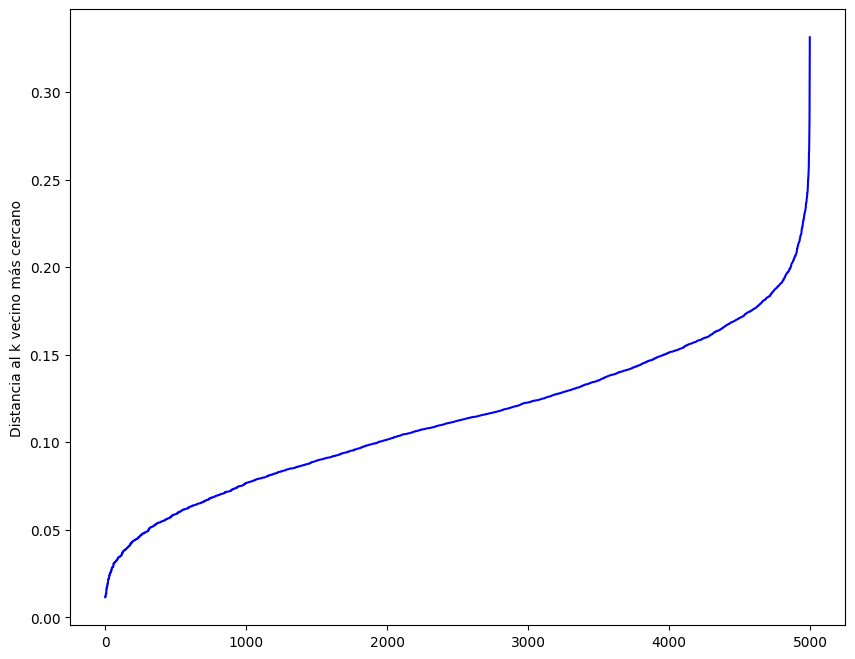

In [ ]:
# Graficar la distancia al vecino más cercano
plt.figure(figsize=(10, 8))
plt.plot(distances, color='blue')
plt.ylabel('Distancia al k vecino más cercano')
plt.show()

Graficamente se puede observar que el codo está ubicado en aproximadamente 4900. Pero este dato se comprobará exactamente por medio de funciones.



In [ ]:
kl = KneeLocator(
    range(len(distances)),
    distances,
    curve='convex',
    direction='increasing')

kl.elbow

4974

Se comprobó de manera analítica que el codo se encuentra ubicado en 4974, que aunque se encuentra casi al final de la muestra trabajada es un hiperparámetro importante para el análisis.

In [ ]:
eps = 1.125 * distances[kl.elbow]
eps

0.2662465565950059

El uso del factor de escala, como el 1.41, en la ecuación para determinar el valor de Eps en el algoritmo DBSCAN proviene de enfoques empíricos utilizados para mejorar la selección de parámetros. El propósito es ajustar el valor de Eps de manera que se identifiquen correctamente los clusters, en especial cuando los datos presentan diferentes densidades.

## **Entrenamiento del modelo de DBSCAN**

In [ ]:
dbscan_2 = DBSCAN(
    eps=eps,
    min_samples=min_samples2)
dbscan_2.fit(df_sample2) # Modelo

labels = dbscan_2.labels_ # Predicción de los clusters
labels

array([ 0,  0,  0, ...,  0,  0, -1])

In [ ]:
#Ver cual podría ser el número maximo de clusters
max(labels)

5

El número total de clusters es 5 (de 0 a 4). Con los hiperparametros ajustados el algoritmo arrojo un número equilibrado de clusters.

### **Resultados modelo DBSCAN**

In [ ]:
print("### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(df_sample2, labels))
print('Calinski-Harabasz Score: ', calinski_harabasz_score(df_sample2, labels))

### DBSCAN ###
Silhouette Score:  -0.23627068676557933
Calinski-Harabasz Score:  17.919080926622126


- Un Silhouette Score negativo indica que los puntos en el dataset están más cerca de puntos de otros clusters que de su propio cluster asignado. Esto sugiere que el modelo DBSCAN está realizando una mala separación de los datos, posiblemente identificando mal los clusters o asignando puntos incorrectamente a ellos.
- Un valor bajo como 17.91 sugiere que los clusters no son compactos ni bien separados. Este puntaje mide la proporción entre la dispersión entre clusters y dentro de los clusters; cuanto mayor sea, mejor es la calidad del clustering.

En conjunto, estos resultados indican que DBSCAN no está logrando identificar una estructura clara en los datos y puede estar generando clusters poco representativos.

In [ ]:
df_sample2.loc[:, 'cluster'] = labels
df_sample2.sort_index(inplace=True)
df_sample2.reset_index(drop=True, inplace=True)
df_sample2.head(50)

Engine_size   Mileage     Price  cluster
0     -1.162105  0.313898  0.151115        0
1     -1.117570 -1.149072 -0.088324        0
2     -1.107557 -1.667533 -1.286436        0
3     -0.945329 -1.530920 -0.905674        0
4     -1.177997 -0.566709 -0.534356        0
5      1.322970  1.722075  1.294389        0
6     -0.659571 -1.588108  1.661971       -1
7      0.128225 -1.151065  0.131308        0
8      0.699980  0.695974  1.482585        0
9     -1.026886 -0.090697  0.289830        0
10    -0.361677 -1.021480  1.685090        0
11    -0.207093  1.431576  0.993557        0
12    -0.684542  0.498414 -1.108601        0
13    -0.390879  0.319859 -1.669384        0
14     0.536551 -1.428277 -1.667339        0
15     1.384771  0.425615  0.842154        0
16    -0.274871  0.260120 -0.776262        0
17    -1.616947 -0.276437 -0.992089        0
18    -0.625082 -0.376318 -0.928793        0
19    -0.025474  1.548258  0.568741        0
20     0.138668 -1.033596 -0.402407        0
21     0.737225 -1.410654  1.194582        0
22    -0.594729 -0.168042  1.442197        0
23    -1.555821  0.715118  1.423237        0
24    -0.411079  1.535041 -1.480060        0
25     0.514870  0.265767  0.873732        0
26    -1.099988  1.720397 -0.419958        0
27     1.542413 -1.211854  0.611737        0
28     0.148079 -0.984765  0.913063        0
29    -0.988858 -0.194057 -0.765478        0
30    -1.710017 -0.809637 -0.647838       -1
31     0.685274  1.430229  1.600507        0
32     0.456441 -0.646660  0.063361        0
33     0.269564 -0.820407  0.540900        0
34    -1.578795 -1.098965 -1.272762        0
35    -0.651450 -1.454012  1.460241       -1
36    -0.379079  0.642930  1.235322        0
37     1.040507  0.861171  0.354888        0
38     0.875365 -1.295703 -1.278612        0
39     0.885553 -0.123792 -0.555502        0
40    -0.530242 -1.509241  0.389003        0
41    -1.161995  1.621669 -0.454849        0
42    -1.274772  1.282882  0.434960        0
43     0.247793 -0.382245 -0.927383        0
44    -0.986113 -0.330075  0.233089        0
45    -1.501227  0.999271 -1.349873        0
46     0.053221  1.206952  1.507467        0
47    -0.040769 -0.500553 -0.457809        0
48    -0.251725 -1.504713 -0.025733        0
49    -0.156788 -1.128144  1.727381        0

- Cluster 0: agrupa la mayoría de los puntos, representando autos con características promedio en cuanto a tamaño de motor, kilometraje y precio.

- Cluster -1: incluye puntos considerados como ruido, es decir, autos con características atípicas o fuera de lo común.

- Cluster 2: contiene autos con motores más pequeños, mayor kilometraje y precios relativamente más altos.

- Cluster 3: Con pocos puntos, agrupa autos con características diferenciadas, posiblemente motores o precios inusuales, lo que sugiere un nicho específico o vehículos con particularidades únicas.

- Cluster 4: También con pocos puntos, puede representar autos exclusivos o extremos en alguna variable, como precios muy altos o motores inusuales, posiblemente separando outliers.

## **Aplicación PCA**

In [ ]:
# Aplicar PCA con 3 componentes
X3 = df_sample2.drop(columns=['cluster'])
pca2 = PCA(n_components=3)
X_pca2 = pca2.fit_transform(X3)

# Crear un nuevo DataFrame con los resultados del PCA
df_pca2 = pd.DataFrame(X_pca2, columns=['PC1', 'PC2', 'PC3'])

In [ ]:
df_pca2

PC1       PC2       PC3
0    -0.764358  0.187807 -0.923224
1    -0.612784 -1.277816 -0.754197
2    -1.333456 -1.968913  0.086868
3    -0.983978 -1.756508 -0.063832
4    -1.077404 -0.782802 -0.469889
...        ...       ...       ...
4995 -0.731910  0.367062 -1.056012
4996  1.174758 -1.584909  1.563266
4997  0.577121  0.211564  0.742971
4998  2.049483 -0.369407 -0.101092
4999 -1.094739  0.229089  0.693143

[5000 rows x 3 columns]

In [ ]:
df_pca2['cluster'] = df_sample2['cluster'].values

# Verifica los resultados
print(df_pca.head(20))

         PC1       PC2       PC3 cluster
0  -0.663219  0.987225 -1.952989       0
1  -0.535667 -1.882654  1.305129       3
2  -1.340363  0.234063  0.307660       2
3  -1.856403 -0.804613 -0.061435       5
4  -0.257482  0.498422 -0.498012       0
5   0.106330 -1.675619  1.334914       3
6  -0.690013  0.427169 -1.501059       1
7  -0.138207 -1.586097 -0.870163       1
8  -0.283420 -1.590128  0.750220       5
9  -0.626449  0.929052  0.637261       2
10  1.764706  1.828225 -0.101708       0
11 -1.105389  1.240602  0.128706       4
12  1.003547 -0.193003  0.618458       3
13 -1.392234 -1.313198 -0.116210       5
14  0.279673 -0.896675 -1.073528       1
15 -0.185538  0.241905  0.495506       4
16 -0.224417 -0.984942  1.512667       3
17 -1.007802  0.748786  0.253856       2
18  0.078573  0.665225  1.200834       4
19  0.279034 -0.096015 -0.724243       1


In [ ]:
# Pesos de las variables que componen las componentes principales
pca2.fit(X)

# Obtener las cargas del PCA
loadings = pca2.components_.T  # Transpuesta para tener las variables como filas

# Crear un DataFrame con las cargas
df_loadings = pd.DataFrame(loadings, index=X.columns, columns=['PC 1', 'PC 2', 'PC 3'])

# Redondear los valores a dos decimales para que sea más legible
df_loadings = df_loadings.round(2)

print(df_loadings)

             PC 1  PC 2  PC 3
Engine_size  0.69  0.12  0.71
Mileage     -0.20  0.98  0.02
Price        0.69  0.15 -0.71


- PC1 está fuertemente influenciado por Engine_size (0.69) y en menor medida por Mileage (-0.19). Esto sugiere que PC1 captura principalmente las variaciones relacionadas con el tamaño del motor y el kilometraje.

- PC2 tiene una mayor carga en Mileage (0.98), lo que indica que esta dimensión está dominada por el kilometraje, separando los autos principalmente según esa característica.

- PC3 tiene una carga importante en Price (0.71) y Engine_size (0.71), lo que implica que este componente principal captura variaciones relacionadas tanto con el precio como con el tamaño del motor.

El resto de las variables, como fabricantes, modelos, tipos de combustible, y año de fabricación, tienen cargas muy bajas, por lo que no contribuyen significativamente a estos tres componentes principales. Esto indica que el PCA está concentrando la variabilidad en las variables relacionadas con el motor, precio, y kilometraje.

### **Visualización gráfica de los clusters**

In [ ]:
# Crear un gráfico 3D interactivo con Plotly
# Asegurarte de que 'cluster' es una columna categórica
df_pca2['cluster'] = df_pca2['cluster'].astype('category')
fig = px.scatter_3d(df_pca2, x='PC1', y='PC2', z='PC3',
                    color='cluster',  # Colorear por clusters
                    title='Clusters utilizando PCA en 3D',
                    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3'},  # Etiquetas de los ejes
                    # Use 'color_discrete_sequence' instead of 'color_continuous_scale' for categorical data
                    color_discrete_sequence=px.colors.qualitative.Set1,
                    size_max=18)

# Mostrar el gráfico interactivo
fig.show()


En el gráfico 3D que muestra los clusters, se observa un solapamiento entre ellos. Este fenómeno puede atribuirse a que el algoritmo DBSCAN no es el más adecuado para analizar datos con poca separación y alta densidad de puntos en una misma área. En tales situaciones, el algoritmo puede confundir puntos que pertenecen a diferentes clusters, tratándolos como si fueran parte de un solo cluster. Según las observaciones, parece que estos datos específicos están altamente agrupados, ya que se pueden identificar clusters dentro de otros clusters.

### **Creación de un modelo usando los datos de PCA**

In [ ]:
min_samples2 = 3 * df_pca2.shape[1]
min_samples2

12

In [ ]:
# Estimación del hiperparámetro de eps
neighbors = NearestNeighbors(n_neighbors=2)
neighbors.fit(df_pca2)
distances, indices = neighbors.kneighbors(df_pca2)

# Ordenar las distancias de cada punto al segundo vecino más cercano
distances = distances[:, 1]
distances = np.sort(distances, axis=0)
print(distances.shape)

(5000,)


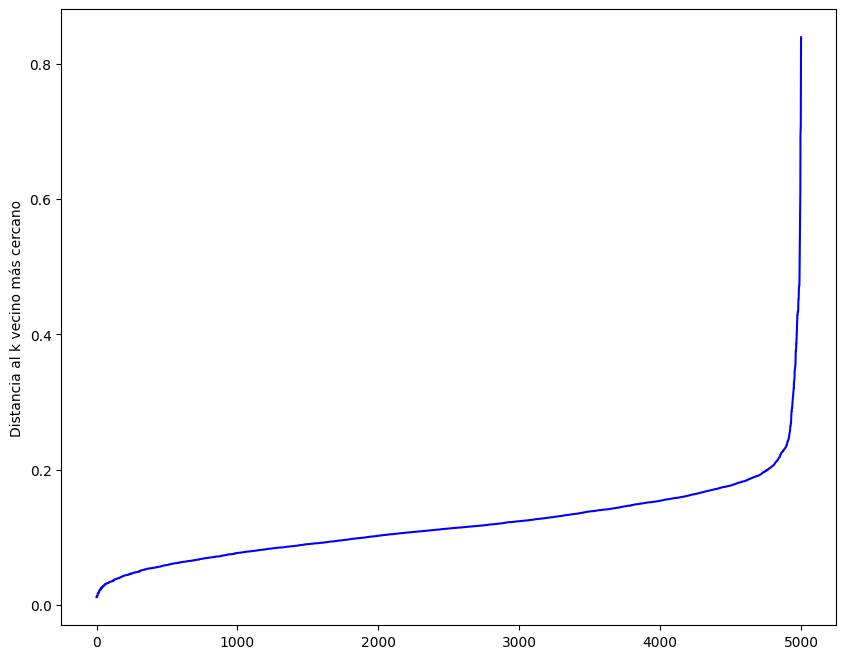

In [ ]:
# Graficar la distancia al vecino más cercano
plt.figure(figsize=(10, 8))
plt.plot(distances, color='blue')
plt.ylabel('Distancia al k vecino más cercano')
plt.show()

In [ ]:
kl = KneeLocator(
    range(len(distances)),
    distances,
    curve='convex',
    direction='increasing')

kl.elbow

4963

In [ ]:
eps = 1.125 * distances[kl.elbow]
eps

0.4232395577745127

In [ ]:
dbscan_2 = DBSCAN(
    eps=eps,
    min_samples=min_samples2)
dbscan_2.fit(df_pca2) # Modelo

labels = dbscan_2.labels_ # Predicción de los clusters

### **Resultados modelo DBSCAN PCA**

In [ ]:
print("### DBSCAN PCA ###")
print('Silhouette Score: ', silhouette_score(df_pca2, labels))
print('Calinski-Harabasz Score: ', calinski_harabasz_score(df_pca2, labels))

### DBSCAN PCA ###
Silhouette Score:  0.18126345867969637
Calinski-Harabasz Score:  60.594258730544595


In [ ]:
mejor_Silhouette_dbscan_pca = silhouette_score(df_pca2, labels)
mejor_Calinski_dbscan_pca = calinski_harabasz_score(df_pca2, labels)

Los resultados del análisis utilizando DBSCAN y PCA indican un Silhouette Score de 0.1812, lo que sugiere que los clusters identificados no están bien definidos y que los puntos pueden estar mal asignados a sus respectivos grupos. Además, el Calinski-Harabasz Score de 60.5942 refuerza esta conclusión, ya que un valor relativamente bajo indica que la separación entre los clusters es insuficiente en comparación con la dispersión interna de los mismos.

## **Comparación de métricas del DBSCAN vs DBSCAN PCA**




In [ ]:
df_sample2=df_sample2.drop(columns=['cluster'])
labels = dbscan_2.labels_
# Metricas para los datos originales con DBSCAN
silhouette_dbscan = silhouette_score(df_sample2, labels)
calinski_dbscan = calinski_harabasz_score(df_sample2, labels)

# Metricas para los datos después de PCA
silhouette_dbscan_pca = silhouette_score(df_pca2, labels)
calinski_dbscan_pca = calinski_harabasz_score(df_pca2, labels)

# Crear un DataFrame para organizar los resultados
results = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Score'],
    'DBSCAN': [silhouette_dbscan, calinski_dbscan],
    'DBSCAN PCA': [silhouette_dbscan_pca, calinski_dbscan_pca]
})

# Aplicar estilo con bordes y centrado
styled_results = results.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center'
}).set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}])

display(styled_results)


Los resultados muestran que, aunque ambos enfoques (DBSCAN y DBSCAN con PCA) presentan un bajo Silhouette Score, lo que indica una pobre cohesión interna en los clústeres, la aplicación de PCA no mejora notablemente el Calinski-Harabasz Score. Esto sugiere que el uso de PCA antes de aplicar DBSCAN resulta en una mejor separación entre los clústeres, haciéndolos más distinguibles y mejor definidos, aunque aún con desafíos en la cohesión interna.

Estos resultados sugieren que podría ser necesario reconsiderar la elección del algoritmo o ajustar los parámetros para obtener una mejor segmentación de los datos.

#Comparación y elección del mejor modelo

In [ ]:
resultados_final = pd.DataFrame([
    ['Mejor modelo K-Means', silhouette_1, calinski_score_1],
    ['Mejor modelo Hierarchical Clustering', mejor_silhouette_hc_pca, mejor_calinski_hc_pca],
    ['Mejor modelo GMM', silhouette_8, calinski_score_8],
    ['Mejor modelo DBSCAN', mejor_Silhouette_dbscan_pca, mejor_Calinski_dbscan_pca]],
    columns = ['Modelo', 'Coeficiente de silueta', 'Calinski Score'])

resultados_final

Modelo  Coeficiente de silueta  \
0                  Mejor modelo K-Means                0.292325   
1  Mejor modelo Hierarchical Clustering                0.422166   
2                      Mejor modelo GMM                0.283073   
3                   Mejor modelo DBSCAN                0.181263   

   Calinski Score  
0     2067.992657  
1     3934.988208  
2     2158.756009  
3       60.594259

Según los resultados obtenidos en el análisis de la base de datos de autos usados, el modelo de Hierarchical Clustering se destaca como el mejor entre los algoritmos de agrupamiento aplicados. Este modelo presenta el mayor Coeficiente de Silueta, lo que indica una cohesión interna más fuerte dentro de los clústeres y una mejor separación entre ellos en comparación con los demás modelos. Adicionalmente, su Calinski-Harabasz Score es el más alto, lo que refuerza que los clústeres generados son compactos y bien definidos. En comparación, los demás modelos, como K-Means, GMM y DBSCAN, muestran valores inferiores tanto en el coeficiente de silueta como en el Calinski-Harabasz Score, sugiriendo que no logran formar clústeres tan bien diferenciados como el método jerárquico.